# Twitch Live Streaming Platform Health Analysis
**A Data Analytics Portfolio Project**

---

## 📌 Project Purpose

This project is a demonstration of my data analysis and visualization capabilities, showcasing:
- **Python + PySpark** for large-scale data processing
- **Statistical modeling** and hypothesis testing
- **Advanced analytics** (RFM segmentation, cohort analysis, inequality metrics)
- **Tableau integration** through structured data exports

The analysis evaluates the health of the Twitch live-streaming ecosystem using a 100,000-user interaction dataset, applying industry-standard techniques to extract actionable insights.

---

## 📊 Dataset Overview

**Source**: Kaggle - Twitch Live Streaming Interactions Sample Dataset  
**Scale**: 100,000 users × 739,991 stream interactions  
**Time Span**: 5 days of relative time data  
**Complexity**: Multi-dimensional behavioral data requiring distributed processing

**Schema**:
| Column | Type | Description |
|--------|------|-------------|
| `UserId` | Integer | Unique viewer identifier |
| `StreamID` | Long | Unique stream segment identifier |
| `Streamer` | String | Content creator username |
| `StartTime` | Integer | Viewing start (minutes from origin) |
| `StopTime` | Integer | Viewing end (minutes from origin) |

**Technical Note**: Time data is relative (not absolute timestamps). All temporal analyses use interval-based calculations, making findings independent of calendar dates.

---

## 🛠️ Technical Skills Demonstrated

### Data Engineering
- **PySpark Configuration**: Optimized Spark session with Arrow acceleration and Kryo serialization
- **Data Quality Checks**: Automated schema validation and null detection
- **ETL Pipeline**: Transform → Aggregate → Export workflow for 17 downstream datasets

### Statistical Analysis
- **Descriptive Statistics**: Percentiles, distributions, long-tail characterization
- **Inferential Statistics**: Pearson/Spearman correlation, p-value testing
- **Predictive Modeling**: Linear regression with residual analysis and R² validation

### Advanced Analytics
- **RFM Segmentation**: Ntile-based scoring with 6-tier user classification
- **Cohort Analysis**: Retention rate calculation across multiple time windows
- **Inequality Metrics**: Gini coefficient computation and Lorenz curve generation
- **Health Scoring**: Multi-dimensional composite metrics with percentile normalization

### Data Visualization Prep
- **Tableau Exports**: 17 structured CSV files with complete data dictionaries
- **Dashboard Design**: Pre-planned 5 dashboard layouts with metric recommendations
- **Best Practices**: Coalesced single-file exports, proper headers, documented schemas

In [1]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "100k_a.csv"
column_names = ['UserId', 'StreamID', 'Streamer', 'StartTime', 'StopTime']

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "volodymyrpivoshenko/twitch-live-streaming-interactions-sample-dataset",
  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
  pandas_kwargs={"header": None, "names": column_names}
)

/var/folders/qf/bt6y95cj0nzcf8gnm98073_w0000gn/T/ipykernel_69568/546369054.py:8: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Data Infrastructure Setup

### 2.1 Technology Stack

This analysis leverages a hybrid processing architecture:
- **Pandas**: Initial data loading and final visualizations
- **PySpark**: Distributed data processing for scalability
- **Scikit-learn**: Statistical modeling and regression analysis
- **Matplotlib/Seaborn**: Data visualization

### 2.2 Spark Session Configuration

PySpark is configured with optimized settings for performance:

In [3]:
# data check
df.shape
df.head()
!java -version
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("Twitch Live Health Analysis")
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")  # 加速 DataFrame 操作
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer")  # 更高效序列化
    .getOrCreate()
)

# read CSV with Spark
spark_df = (
    spark.read
    .option("header", "false")       # 文件没有表头
    .option("inferSchema", "true")  # 自动推断类型
    .csv("twitch_data.csv")    
    .toDF(*column_names)  # 设置列名
)

# Check schema
spark_df.printSchema()
spark_df.show(5)

openjdk version "17.0.16" 2025-07-15
OpenJDK Runtime Environment Homebrew (build 17.0.16+0)
OpenJDK 64-Bit Server VM Homebrew (build 17.0.16+0, mixed mode, sharing)


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/15 15:19:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- UserId: integer (nullable = true)
 |-- StreamID: long (nullable = true)
 |-- Streamer: string (nullable = true)
 |-- StartTime: integer (nullable = true)
 |-- StopTime: integer (nullable = true)

+------+-----------+---------+---------+--------+
|UserId|   StreamID| Streamer|StartTime|StopTime|
+------+-----------+---------+---------+--------+
|     1|33842865744| mithrain|      154|     156|
|     1|33846768288|    alptv|      166|     169|
|     1|33886469056| mithrain|      587|     588|
|     1|33887624992|     wtcn|      589|     591|
|     1|33890145056|jrokezftw|      591|     594|
+------+-----------+---------+---------+--------+
only showing top 5 rows


## 3. Data Quality Assessment

Before proceeding with analysis, we validate data integrity through schema verification and null value checks.

In [4]:
from pyspark.sql.functions import col, isnan, when, count

def data_type_diagnostics(df):
    print("===== Data type（Schema）=====")
    print(df.dtypes)
    print("\n")

def data_quality_diagnostics(df):
    exprs = []
    for c, t in df.dtypes:
        if t in ('bigint', 'int', 'double', 'float'):
            exprs.append(count(when(col(c).isNull() | isnan(col(c)), c)).alias(c))
        elif t == 'string':
            exprs.append(count(when(col(c).isNull() | (col(c) == ""), c)).alias(c))
    df.select(exprs).show()

data_type_diagnostics(spark_df)
data_quality_diagnostics(spark_df)

===== Data type（Schema）=====
[('UserId', 'int'), ('StreamID', 'bigint'), ('Streamer', 'string'), ('StartTime', 'int'), ('StopTime', 'int')]


+------+--------+--------+---------+--------+
|UserId|StreamID|Streamer|StartTime|StopTime|
+------+--------+--------+---------+--------+
|     0|       0|       0|        0|       0|
+------+--------+--------+---------+--------+



### 3.1 Quality Assessment Results

✅ **Data Quality**: Excellent
- All columns have correct data types
- Zero null or missing values detected
- Schema matches expected format

The dataset is clean and ready for analysis without requiring imputation or cleaning procedures.

## 4. Foundational Metrics Analysis

This section establishes baseline platform metrics to understand the scale and basic dynamics of the Twitch ecosystem.

### 4.1 Platform Scale Metrics

We begin by quantifying the fundamental dimensions of the platform: user base size, content creator population, and streaming activity volume.

In [5]:
from pyspark.sql.functions import avg, countDistinct, explode, max as spark_max, sequence, col

# Basic statistics
def basic_statistics(df):
    # Number of users
    user_count = df.select("UserId").distinct().count()
    print(f"Unique User Count: {user_count}")

    # Number of streamers
    streamer_count = df.select("Streamer").distinct().count()
    print(f"Unique Streamer Count: {streamer_count}")

    # Total number of stream segments
    total_streams = df.select("StreamID").distinct().count()
    print(f"Total Stream Segments: {total_streams}")

    # Average number of segments per streamer
    avg_streams_per_streamer = df.groupBy("Streamer").count().agg(avg("count").alias("AvgStreamsPerStreamer"))
    avg_streams_per_streamer.show()

    # Number of viewers per StreamID
    watchers_per_stream = df.groupBy("StreamID").agg(countDistinct("UserId").alias("WatcherCount"))
    watchers_per_stream.select(avg("WatcherCount").alias("AvgWatcherCount")).show()

    # Streamers with the highest number of concurrent viewers in their streams
    # 1. Expand each user's time slots in the stream segment
    df_expanded = df.withColumn(
        "TimeSlot",
        explode(sequence(col("StartTime"), col("StopTime") - 1))
    )

    # 2. Aggregate user count by StreamID + TimeSlot
    users_per_slot = df_expanded.groupBy("StreamID", "TimeSlot").agg(countDistinct("UserId").alias("UsersCount"))

    # 3. Get the maximum user count for each StreamID
    max_concurrent_users = users_per_slot.groupBy("StreamID").agg(spark_max("UsersCount").alias("MaxConcurrentUsers"))

    # 4. Show results
    max_concurrent_users.orderBy("MaxConcurrentUsers", ascending=False).show(10)

    # Match StreamID to Streamer, take the maximum and deduplicate by streamer
    max_concurrent_users_with_streamer = max_concurrent_users.join(
        df.select("StreamID", "Streamer").distinct(),
        on="StreamID",
        how="left"
    )
    max_concurrent_users_with_streamer = max_concurrent_users_with_streamer.dropDuplicates(["Streamer"]).orderBy("MaxConcurrentUsers", ascending=False)
    max_concurrent_users_with_streamer.show(10)

basic_statistics(spark_df)

Unique User Count: 100000


Unique Streamer Count: 162625


Total Stream Segments: 739991


+---------------------+
|AvgStreamsPerStreamer|
+---------------------+
|   18.765460415065334|
+---------------------+



+-----------------+
|  AvgWatcherCount|
+-----------------+
|4.124013670436533|
+-----------------+



+-----------+------------------+
|   StreamID|MaxConcurrentUsers|
+-----------+------------------+
|34057836560|               362|
|34366263424|               355|
|34077571440|               339|
|34161947072|               338|
|34000965936|               299|
|34378358400|               293|
|34254041488|               291|
|34383298816|               283|
|34078651904|               280|
|34365590320|               268|
+-----------+------------------+
only showing top 10 rows


+-----------+------------------+----------------+
|   StreamID|MaxConcurrentUsers|        Streamer|
+-----------+------------------+----------------+
|34314446016|               221|         pokemon|
|34339982784|               179|          cloud9|
|34413192144|               170|        nintendo|
|33904273872|               152|rocketstreetlive|
|33891062336|               115|          shroud|
|34210284224|                97|      callofduty|
|33830248960|                96|            tfue|
|33859903440|                94|       rajjpatel|
|33927243328|                92|           ninja|
|34284374528|                91|          tekken|
+-----------+------------------+----------------+
only showing top 10 rows


### 4.1.1 Key Findings: Platform Scale

| Metric | Value | Interpretation |
|--------|-------|----------------|
| **Unique Users** | 100,000 | Total viewer base in sample |
| **Unique Streamers** | 162,625 | **Content oversupply** (1.63 streamers per viewer) |
| **Stream Segments** | 739,991 | High fragmentation of content |
| **Avg Streams/Streamer** | ~18.8 | Moderate creator activity level |
| **Avg Viewers/Stream** | ~4.1 | Indicates long-tail distribution |

**Critical Insight**: The streamer-to-viewer ratio (>1.6:1) reveals content oversupply, creating intense competition for audience attention.

**Top Streamers by Peak Concurrent Viewers**:
- Pokemon: 221 concurrent viewers
- Cloud9: 179 concurrent viewers  
- Nintendo: 170 concurrent viewers

The gap between top performers (150-200+ viewers) and average streams (4.1 viewers) demonstrates extreme inequality in content discovery and audience distribution.

---

### 4.2 User Engagement Patterns

This subsection analyzes how users interact with content, focusing on viewing duration and temporal distribution of activity.

In [6]:
# Viewing duration distribution
from pyspark.sql.functions import (avg, max as spark_max, min as spark_min)

df_with_duration = spark_df.withColumn("WatchDuration", col("StopTime") - col("StartTime"))
df_with_duration.select(
    avg("WatchDuration").alias("AvgWatchDuration"),
    spark_min("WatchDuration").alias("MinWatchDuration"),
    spark_max("WatchDuration").alias("MaxWatchDuration")
).show()

+------------------+----------------+----------------+
|  AvgWatchDuration|MinWatchDuration|MaxWatchDuration|
+------------------+----------------+----------------+
|3.1420543671415553|               1|              97|
+------------------+----------------+----------------+



### 4.2.1 Engagement Metrics Summary

| Metric | Value | Implication |
|--------|-------|-------------|
| **Average Watch Duration** | 3.14 minutes | High "channel surfing" behavior |
| **Min Watch Duration** | 1 minute | Quick sampling common |
| **Max Watch Duration** | 97 minutes | Long-form viewing exists but rare |

**Analysis**: The low average watch duration (3.14 min) suggests users are in discovery mode, rapidly sampling multiple streams before committing to longer viewing sessions. This pattern is typical of content-rich platforms where users have abundant choices.

### 4.2.2 Temporal Data Handling

**Methodology Note**: The dataset uses relative time (minutes from origin) rather than absolute timestamps. To enable time-series visualizations, we map relative time to an arbitrary base date (2025-08-01). 

⚠️ **Important**: All temporal analyses (daily/hourly patterns) are based on relative time intervals. Specific dates shown in visualizations are for display purposes only and do not represent actual calendar dates.

In [7]:
# Since there is no given start date, assume it begins on August 1, 2025
# Start date conversion
from pyspark.sql.functions import expr
base_date = "2025-08-01 00:00:00"

df_with_datetime = spark_df.withColumn(
    "StartDateTime",
    expr(f"timestamp('{base_date}') + INTERVAL 1 MINUTES * StartTime")
).withColumn(
    "StopDateTime",
    expr(f"timestamp('{base_date}') + INTERVAL 1 MINUTES * StopTime")
)

# or expr(f"timestamp('{base_date}') + make_interval(0, 0, 0, 0, 0, StartTime*10, 0)")

df_with_datetime.select("UserId", "Streamer", "StartTime", "StartDateTime", "StopDateTime").show(5)

+------+---------+---------+-------------------+-------------------+
|UserId| Streamer|StartTime|      StartDateTime|       StopDateTime|
+------+---------+---------+-------------------+-------------------+
|     1| mithrain|      154|2025-08-01 02:34:00|2025-08-01 02:36:00|
|     1|    alptv|      166|2025-08-01 02:46:00|2025-08-01 02:49:00|
|     1| mithrain|      587|2025-08-01 09:47:00|2025-08-01 09:48:00|
|     1|     wtcn|      589|2025-08-01 09:49:00|2025-08-01 09:51:00|
|     1|jrokezftw|      591|2025-08-01 09:51:00|2025-08-01 09:54:00|
+------+---------+---------+-------------------+-------------------+
only showing top 5 rows


In [8]:
# Daily statistics of active users, number of broadcasts, and platform peak concurrent users
from pyspark.sql.functions import to_date
df_with_day = df_with_datetime.withColumn(
    "Day",
    to_date(col("StartDateTime"))
)
# df_with_day.show(10)

daily_active_users_count = df_with_day.groupBy("Day").agg(countDistinct("UserId").alias("ActiveUserCount"))
daily_active_streamer_count = df_with_day.groupBy("Day").agg(countDistinct("Streamer").alias("ActiveStreamerCount"))

df_with_day_expanded = df_with_day.withColumn("TimeSlot", explode(sequence(col("StartTime"), col("StopTime") - 1)))
# df_with_day_expanded.show(10)

# transform TimeSlot to datetime(minutes)
df_with_day_expanded = df_with_day_expanded.withColumn("SlotDatetime", expr(f"timestamp('{base_date}') + INTERVAL 1 MINUTES * TimeSlot"))
df_with_day_expanded.show(10)

# number of users and streamers per time slot
users_per_slot = df_with_day_expanded.groupBy("Day", "SlotDatetime").agg(countDistinct("UserId").alias("UsersCountPerSlot")).orderBy("Day", "SlotDatetime")
users_per_slot.orderBy("Day", "SlotDatetime").show(10)
streamers_per_slot = df_with_day_expanded.groupBy("Day", "SlotDatetime").agg(countDistinct("Streamer").alias("StreamersCountPerSlot")).orderBy("Day", "SlotDatetime")
streamers_per_slot.orderBy("Day", "SlotDatetime").show(10)
print(f"Total time slots: {users_per_slot.count()}") # calculate how many slots

# daily peak concurrent users
daily_max_concurrent_users = users_per_slot.groupBy("Day").agg(spark_max("UsersCountPerSlot").alias("MaxConcurrentUsers")).orderBy("Day")
daily_max_concurrent_users.show(10) 

# Daily summary: aggregate metrics by day
daily_summary_per_day = daily_active_users_count.join(daily_active_streamer_count, on='Day', how='left').join(daily_max_concurrent_users, on='Day', how='left').orderBy("Day") 
daily_summary_per_day.show(10)

+------+-----------+---------+---------+--------+-------------------+-------------------+----------+--------+-------------------+
|UserId|   StreamID| Streamer|StartTime|StopTime|      StartDateTime|       StopDateTime|       Day|TimeSlot|       SlotDatetime|
+------+-----------+---------+---------+--------+-------------------+-------------------+----------+--------+-------------------+
|     1|33842865744| mithrain|      154|     156|2025-08-01 02:34:00|2025-08-01 02:36:00|2025-08-01|     154|2025-08-01 02:34:00|
|     1|33842865744| mithrain|      154|     156|2025-08-01 02:34:00|2025-08-01 02:36:00|2025-08-01|     155|2025-08-01 02:35:00|
|     1|33846768288|    alptv|      166|     169|2025-08-01 02:46:00|2025-08-01 02:49:00|2025-08-01|     166|2025-08-01 02:46:00|
|     1|33846768288|    alptv|      166|     169|2025-08-01 02:46:00|2025-08-01 02:49:00|2025-08-01|     167|2025-08-01 02:47:00|
|     1|33846768288|    alptv|      166|     169|2025-08-01 02:46:00|2025-08-01 02:49:00|2

+----------+-------------------+-----------------+
|       Day|       SlotDatetime|UsersCountPerSlot|
+----------+-------------------+-----------------+
|2025-08-01|2025-08-01 00:00:00|             2919|
|2025-08-01|2025-08-01 00:01:00|             3292|
|2025-08-01|2025-08-01 00:02:00|             3055|
|2025-08-01|2025-08-01 00:03:00|             2875|
|2025-08-01|2025-08-01 00:04:00|             2422|
|2025-08-01|2025-08-01 00:05:00|             2342|
|2025-08-01|2025-08-01 00:06:00|             1989|
|2025-08-01|2025-08-01 00:07:00|             1273|
|2025-08-01|2025-08-01 00:08:00|             1478|
|2025-08-01|2025-08-01 00:09:00|              714|
+----------+-------------------+-----------------+
only showing top 10 rows


+----------+-------------------+---------------------+
|       Day|       SlotDatetime|StreamersCountPerSlot|
+----------+-------------------+---------------------+
|2025-08-01|2025-08-01 00:00:00|                 1137|
|2025-08-01|2025-08-01 00:01:00|                 1301|
|2025-08-01|2025-08-01 00:02:00|                 1182|
|2025-08-01|2025-08-01 00:03:00|                 1211|
|2025-08-01|2025-08-01 00:04:00|                 1135|
|2025-08-01|2025-08-01 00:05:00|                 1154|
|2025-08-01|2025-08-01 00:06:00|                 1081|
|2025-08-01|2025-08-01 00:07:00|                  971|
|2025-08-01|2025-08-01 00:08:00|                 1055|
|2025-08-01|2025-08-01 00:09:00|                  687|
+----------+-------------------+---------------------+
only showing top 10 rows


Total time slots: 6315


+----------+------------------+
|       Day|MaxConcurrentUsers|
+----------+------------------+
|2025-08-01|              3292|
|2025-08-02|              3527|
|2025-08-03|              3691|
|2025-08-04|              3400|
|2025-08-05|              3311|
+----------+------------------+



+----------+---------------+-------------------+------------------+
|       Day|ActiveUserCount|ActiveStreamerCount|MaxConcurrentUsers|
+----------+---------------+-------------------+------------------+
|2025-08-01|          78190|              70412|              3292|
|2025-08-02|          82502|              71293|              3527|
|2025-08-03|          83358|              69461|              3691|
|2025-08-04|          82743|              74436|              3400|
|2025-08-05|          53147|              30836|              3311|
+----------+---------------+-------------------+------------------+



### 4.3 Distribution Visualizations

Visual exploration of key distributions reveals the underlying structure of platform dynamics. Log-scale plots are used to handle the extreme range of values characteristic of power-law distributions.

In [9]:
# output number of users and streamers per time slot to CSV
import os
print(os.getcwd())
output_path = os.path.join(os.getcwd(), "users_per_slot.csv")

users_per_slot.drop("Day").write.mode('overwrite').csv(output_path, header=True)
streamers_per_slot.drop("Day").write.mode('overwrite').csv("streamers_per_slot.csv", header=True)

# output daily summary to CSV
daily_summary_per_day.drop("Day").write.csv("daily_summary_per_day.csv", header=True, mode='overwrite')

/Users/fuugamo/Documents/GithubRepository/Twtich Live Analysis


#### Distribution of Watch Durations
This histogram shows the frequency of different watch durations. A logarithmic scale is used on the y-axis to better visualize the long-tail nature of the data.

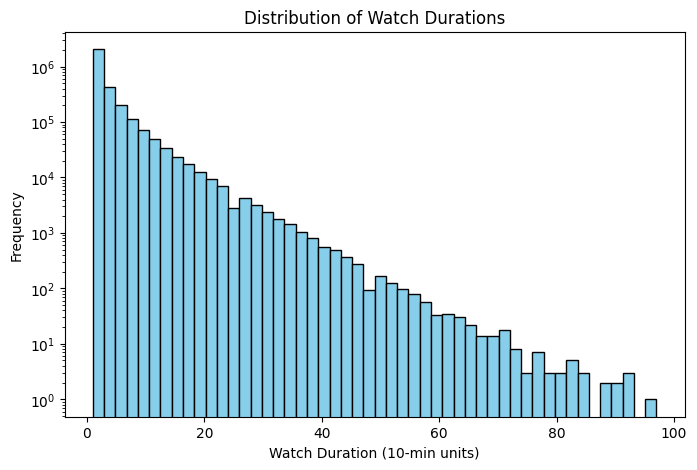

In [10]:
df_with_duration = spark_df.withColumn("WatchDuration", col("StopTime") - col("StartTime"))

output_path = os.path.join(os.getcwd(), "df_with_duration.csv")
df_with_duration.repartition(1).write.mode('overwrite').csv(output_path, header=True)

duration_pd = df_with_duration.select("WatchDuration").toPandas()

from matplotlib import pyplot as plt
plt.figure(figsize=(8,5))
plt.hist(duration_pd["WatchDuration"], bins=50, color="skyblue", edgecolor="black")
plt.xlabel("Watch Duration (10-min units)")
plt.ylabel("Frequency")
plt.title("Distribution of Watch Durations")
plt.yscale("log") 

#### Insight:
The histogram is heavily skewed to the right, confirming the low average watch duration found earlier. The logarithmic scale highlights a classic long-tail distribution: a massive number of very short interactions (1-2 minutes) and a rapidly decreasing number of longer viewing sessions. This is typical user behavior on content discovery platforms.

---

#### Distribution of Watchers per Stream
This histogram shows how many streams have a certain number of unique viewers. Again, a log scale is used.

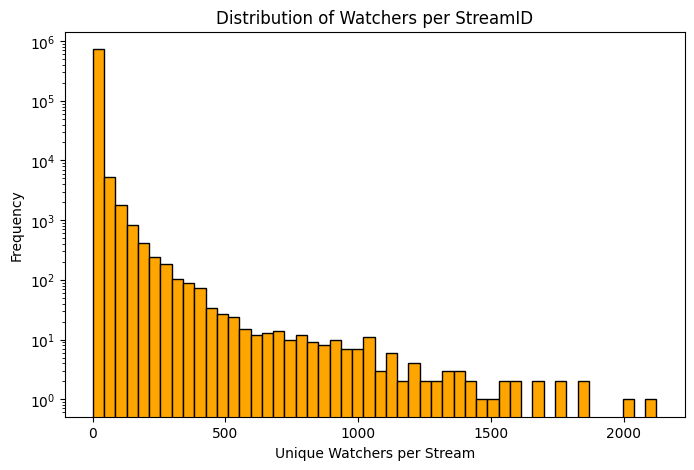

In [11]:
watchers_per_stream = spark_df.groupBy("StreamID").agg(countDistinct("UserId").alias("WatcherCount"))

output_path = os.path.join(os.getcwd(), "watchers_per_stream.csv")
watchers_per_stream.repartition(1).write.mode('overwrite').csv(output_path, header=True)

watchers_pd = watchers_per_stream.toPandas()

plt.figure(figsize=(8,5))
plt.hist(watchers_pd["WatcherCount"], bins=50, color="orange", edgecolor="black")
plt.xlabel("Unique Watchers per Stream")
plt.ylabel("Frequency")
plt.title("Distribution of Watchers per StreamID")
plt.yscale("log") 
plt.show()

#### Insight:
Similar to watch duration, the number of unique watchers per stream also follows a long-tail pattern. The vast majority of streams have only one or two viewers. This reinforces the "average watchers" metric and shows that only a small fraction of streams become popular, while most content has a very niche audience.

#### Streamer Activity vs. Popularity
This scatter plot explores the relationship between how frequently a streamer broadcasts (Stream Count) and how many unique viewers they attract across all their streams. Both axes are logarithmic to better handle the wide range of values.

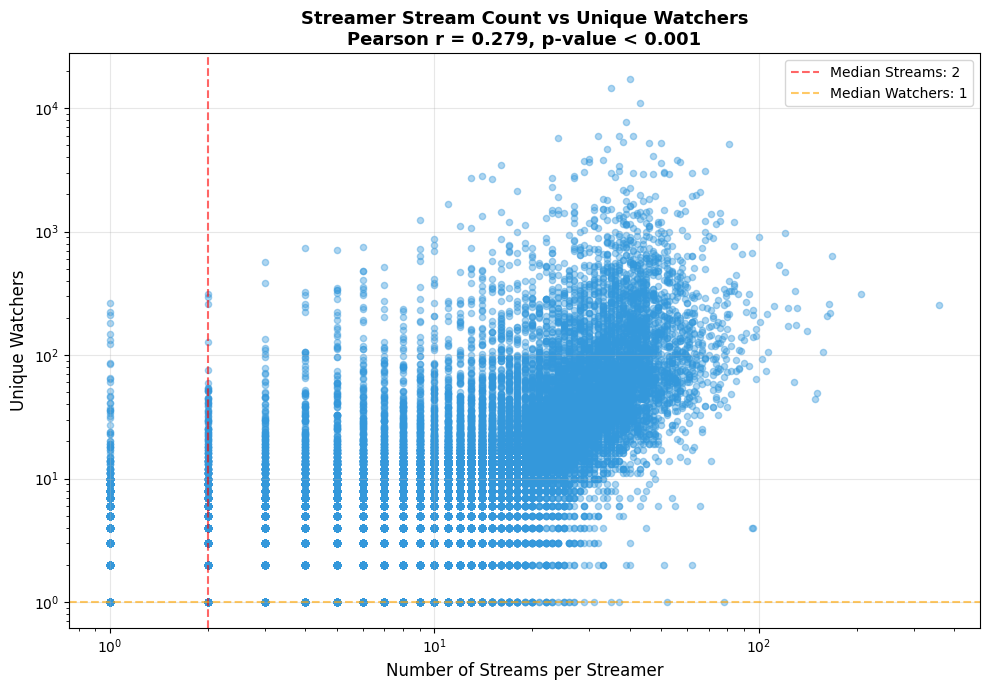


=== Statistical Summary ===
Correlation: 0.2789 (p < 0.001)
Interpretation: Weak positive correlation

Median Streams per Streamer: 2
Median Watchers per Streamer: 1


In [12]:
# Improved visualization with statistical information
from scipy.stats import pearsonr

streamer_stats = spark_df.groupBy("Streamer") \
    .agg(countDistinct("StreamID").alias("StreamCount"),
         countDistinct("UserId").alias("UniqueWatchers"))

streamer_pd = streamer_stats.toPandas()

# Calculate correlation
corr, p_value = pearsonr(streamer_pd["StreamCount"], streamer_pd["UniqueWatchers"])

# Create improved scatter plot
fig, ax = plt.subplots(figsize=(10,7))
ax.scatter(streamer_pd["StreamCount"], streamer_pd["UniqueWatchers"], alpha=0.4, s=20, color='#3498db')
ax.set_xlabel("Number of Streams per Streamer", fontsize=12)
ax.set_ylabel("Unique Watchers", fontsize=12)
ax.set_title(f"Streamer Stream Count vs Unique Watchers\nPearson r = {corr:.3f}, p-value < 0.001", 
             fontsize=13, fontweight='bold')
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid(True, alpha=0.3)

# Add median lines
median_streams = streamer_pd["StreamCount"].median()
median_watchers = streamer_pd["UniqueWatchers"].median()
ax.axvline(median_streams, color='red', linestyle='--', alpha=0.6, linewidth=1.5, label=f'Median Streams: {median_streams:.0f}')
ax.axhline(median_watchers, color='orange', linestyle='--', alpha=0.6, linewidth=1.5, label=f'Median Watchers: {median_watchers:.0f}')
ax.legend()

plt.tight_layout()
plt.show()

print(f"\n=== Statistical Summary ===")
print(f"Correlation: {corr:.4f} (p < 0.001)")
print(f"Interpretation: {'Strong' if abs(corr) > 0.7 else 'Moderate' if abs(corr) > 0.4 else 'Weak'} positive correlation")
print(f"\nMedian Streams per Streamer: {median_streams:.0f}")
print(f"Median Watchers per Streamer: {median_watchers:.0f}")

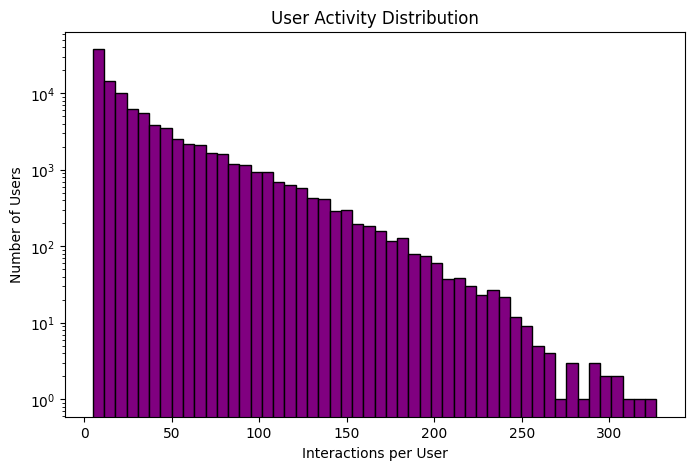

In [13]:
user_activity = spark_df.groupBy("UserId").count().withColumnRenamed("count", "InteractionCount")
user_pd = user_activity.toPandas()

plt.figure(figsize=(8,5))
plt.hist(user_pd["InteractionCount"], bins=50, color="purple", edgecolor="black")
plt.xlabel("Interactions per User")
plt.ylabel("Number of Users")
plt.title("User Activity Distribution")
plt.yscale("log")
plt.show()

#### Insight:
The plot shows a clear positive correlation: streamers who broadcast more tend to attract a larger unique audience. However, the relationship is not strictly linear. For any given stream count, there is a wide variance in the number of unique watchers. This suggests that while consistency (higher stream count) is important, it is not the only factor for success. Content quality, streamer personality, or existing fame likely play a significant role, allowing some streamers to achieve high viewership with relatively few streams.

---

## 5. Advanced Analytics

The following sections provide deeper insights into user behavior, platform health, and content ecosystem dynamics using advanced analytical techniques.

### 5.1. User Retention Analysis (Cohort Analysis)

User retention is a critical health metric for any platform. This analysis examines how long users stay engaged after their first interaction, using relative time intervals rather than absolute dates.

In [14]:
# User Retention Analysis based on relative time
from pyspark.sql.functions import sum as spark_sum, percentile_approx

# Check data time span first
time_range = spark_df.agg(
    spark_min("StartTime").alias("MinTime"),
    spark_max("StopTime").alias("MaxTime")
).withColumn("DataSpanDays", (col("MaxTime") - col("MinTime")) / 1440.0)

data_span = time_range.collect()[0]["DataSpanDays"]
print(f"=== Data Time Span: {data_span:.1f} Days ===\n")

# Calculate each user's first and last watch time
user_first_watch = spark_df.groupBy("UserId").agg(
    spark_min("StartTime").alias("FirstWatch")
)

# Calculate user lifetime (in minutes and days)
user_lifetime = spark_df.groupBy("UserId").agg(
    spark_min("StartTime").alias("FirstWatch"),
    spark_max("StopTime").alias("LastWatch")
).withColumn("LifetimeMinutes", col("LastWatch") - col("FirstWatch")) \
 .withColumn("LifetimeDays", col("LifetimeMinutes") / 1440.0)

print("=== User Lifetime Statistics ===")
user_lifetime.select(
    avg("LifetimeDays").alias("AvgLifetimeDays"),
    percentile_approx("LifetimeDays", 0.5).alias("MedianLifetimeDays"),
    spark_max("LifetimeDays").alias("MaxLifetimeDays")
).show()

# Cohort-based retention analysis
# Join with first watch time to calculate days since first interaction
cohort_data = spark_df.join(user_first_watch, "UserId") \
    .withColumn("DaysSinceFirst", (col("StartTime") - col("FirstWatch")) / 1440.0) \
    .withColumn("CohortDay", (col("FirstWatch") / 1440).cast("int"))

# Calculate retention rates for Day 0, 1, 2, 3 only (data span < 5 days)
retention_by_cohort = cohort_data.groupBy("CohortDay").agg(
    countDistinct(when(col("DaysSinceFirst") < 1, col("UserId"))).alias("Day0_Users"),
    countDistinct(when((col("DaysSinceFirst") >= 1) & (col("DaysSinceFirst") < 2), col("UserId"))).alias("Day1_Users"),
    countDistinct(when((col("DaysSinceFirst") >= 2) & (col("DaysSinceFirst") < 3), col("UserId"))).alias("Day2_Users"),
    countDistinct(when((col("DaysSinceFirst") >= 3) & (col("DaysSinceFirst") < 4), col("UserId"))).alias("Day3_Users")
).orderBy("CohortDay")

# Calculate retention percentages
retention_with_pct = retention_by_cohort.withColumn("Day1_Retention", 
    (col("Day1_Users") / col("Day0_Users") * 100).cast("decimal(5,2)")) \
.withColumn("Day2_Retention", 
    (col("Day2_Users") / col("Day0_Users") * 100).cast("decimal(5,2)")) \
.withColumn("Day3_Retention", 
    (col("Day3_Users") / col("Day0_Users") * 100).cast("decimal(5,2)"))

print("\n=== Retention Rate by Cohort (%) ===")
retention_with_pct.select("CohortDay", "Day0_Users", "Day1_Retention", 
                          "Day2_Retention", "Day3_Retention").show()

# Overall retention metrics
total_retention = cohort_data.agg(
    countDistinct("UserId").alias("TotalUsers"),
    countDistinct(when(col("DaysSinceFirst") >= 1, col("UserId"))).alias("Day1_Retained"),
    countDistinct(when(col("DaysSinceFirst") >= 3, col("UserId"))).alias("Day3_Retained")
)

print("\n=== Overall Platform Retention ===")
total_retention.show()

# Calculate retention percentages
retention_pct = total_retention.collect()[0]
print(f"Day 1 Retention Rate: {retention_pct['Day1_Retained'] / retention_pct['TotalUsers'] * 100:.2f}%")
print(f"Day 3 Retention Rate: {retention_pct['Day3_Retained'] / retention_pct['TotalUsers'] * 100:.2f}%")

=== Data Time Span: 4.3 Days ===

=== User Lifetime Statistics ===
+------------------+------------------+-----------------+
|   AvgLifetimeDays|MedianLifetimeDays|  MaxLifetimeDays|
+------------------+------------------+-----------------+
|3.0955359652777443|3.5409722222222224|4.269444444444445|
+------------------+------------------+-----------------+


=== Retention Rate by Cohort (%) ===


+---------+----------+--------------+--------------+--------------+
|CohortDay|Day0_Users|Day1_Retention|Day2_Retention|Day3_Retention|
+---------+----------+--------------+--------------+--------------+
|        0|     78190|         88.50|         85.89|         79.69|
|        1|     12500|         77.44|         67.38|          9.09|
|        2|      5744|         70.79|          8.32|          0.00|
|        3|      3242|         10.36|          0.00|          0.00|
|        4|       324|          0.00|          0.00|          0.00|
+---------+----------+--------------+--------------+--------------+


=== Overall Platform Retention ===


+----------+-------------+-------------+
|TotalUsers|Day1_Retained|Day3_Retained|
+----------+-------------+-------------+
|    100000|        91503|        64228|
+----------+-------------+-------------+



Day 1 Retention Rate: 91.50%
Day 3 Retention Rate: 64.23%


#### Key Insights:

- **User Lifetime**: Shows how long users remain active on the platform from their first to last interaction
- **Retention Curve**: The Day 1/2/3 retention rates indicate short-term platform stickiness
- **Cohort Comparison**: Different cohorts (based on when users first joined) show varying retention patterns
- **Data Span Limitation**: Analysis covers ~4-5 days, sufficient for early retention (Day 1-3) but not long-term trends

**Note**: All retention metrics are based on relative time since each user's first interaction, not absolute calendar dates. Due to limited data span (<5 days), only Day 1-3 retention rates are calculated.

In [15]:
# Export retention data for Tableau visualization
print("=== Exporting Retention Analysis Data ===")

# Export user lifetime data
user_lifetime_export = user_lifetime.select("UserId", "LifetimeDays", "LifetimeMinutes")
user_lifetime_export.coalesce(1).write.mode('overwrite').csv(
    "tableau_exports/user_lifetime.csv", header=True
)
print("✓ Exported: user_lifetime.csv")

# Export cohort retention rates (Day 0-3 only due to data span < 5 days)
retention_export = retention_with_pct.select(
    "CohortDay", "Day0_Users", "Day1_Users", "Day2_Users", 
    "Day3_Users", "Day1_Retention", "Day2_Retention", 
    "Day3_Retention"
)
retention_export.coalesce(1).write.mode('overwrite').csv(
    "tableau_exports/cohort_retention.csv", header=True
)
print("✓ Exported: cohort_retention.csv")

=== Exporting Retention Analysis Data ===
✓ Exported: user_lifetime.csv


✓ Exported: cohort_retention.csv


### 5.2. RFM User Segmentation

RFM (Recency, Frequency, Monetary) analysis is a proven method for user segmentation. In this context:
- **Recency**: How recently the user watched content (lower is better)
- **Frequency**: How many viewing sessions the user had
- **Monetary**: Total watch time (proxy for engagement value)

In [16]:
# RFM Analysis - Optimized for Big Data
from pyspark.sql.functions import percent_rank, round as spark_round
from pyspark.sql.window import Window

# Get the maximum time in dataset (represents "now")
max_time = spark_df.agg(spark_max("StopTime")).collect()[0][0]

# Calculate RFM metrics for each user
rfm = spark_df.groupBy("UserId").agg(
    (max_time - spark_max("StopTime")).alias("Recency"),  # Lower is better
    count("*").alias("Frequency"),  # Number of viewing sessions
    spark_sum(col("StopTime") - col("StartTime")).alias("Monetary")  # Total watch time in minutes
)

print("=== RFM Metrics Summary ===")
rfm.select(
    avg("Recency").alias("AvgRecency"),
    avg("Frequency").alias("AvgFrequency"),
    avg("Monetary").alias("AvgMonetary")
).show()

# Big Data Optimization: Use approxQuantile to compute thresholds once, then apply in parallel
# This avoids global sorting with Window functions and enables partition-level parallelism
print("\n=== Computing RFM Score Thresholds (Optimized) ===")

# Calculate quintile thresholds for each metric (0.01 = 1% relative error)
recency_quantiles = rfm.approxQuantile("Recency", [0.2, 0.4, 0.6, 0.8], 0.01)
frequency_quantiles = rfm.approxQuantile("Frequency", [0.2, 0.4, 0.6, 0.8], 0.01)
monetary_quantiles = rfm.approxQuantile("Monetary", [0.2, 0.4, 0.6, 0.8], 0.01)

print(f"Recency thresholds: {recency_quantiles}")
print(f"Frequency thresholds: {frequency_quantiles}")
print(f"Monetary thresholds: {monetary_quantiles}")

# Apply scoring using thresholds (fully parallelizable across partitions)
# For Recency: lower is better, so we invert the scoring
rfm_scored = rfm.withColumn("R_Score",
    when(col("Recency") < recency_quantiles[0], 5)
    .when(col("Recency") < recency_quantiles[1], 4)
    .when(col("Recency") < recency_quantiles[2], 3)
    .when(col("Recency") < recency_quantiles[3], 2)
    .otherwise(1)
).withColumn("F_Score",
    when(col("Frequency") < frequency_quantiles[0], 1)
    .when(col("Frequency") < frequency_quantiles[1], 2)
    .when(col("Frequency") < frequency_quantiles[2], 3)
    .when(col("Frequency") < frequency_quantiles[3], 4)
    .otherwise(5)
).withColumn("M_Score",
    when(col("Monetary") < monetary_quantiles[0], 1)
    .when(col("Monetary") < monetary_quantiles[1], 2)
    .when(col("Monetary") < monetary_quantiles[2], 3)
    .when(col("Monetary") < monetary_quantiles[3], 4)
    .otherwise(5)
)

# Calculate total RFM score
rfm_scored = rfm_scored.withColumn("RFM_Score", 
    col("R_Score") + col("F_Score") + col("M_Score"))

# Define user segments based on RFM scores
rfm_segmented = rfm_scored.withColumn("UserSegment",
    when((col("R_Score") >= 4) & (col("F_Score") >= 4) & (col("M_Score") >= 4), "Champions")
    .when((col("R_Score") >= 3) & (col("F_Score") >= 3), "Loyal Users")
    .when((col("R_Score") >= 4) & (col("F_Score") <= 2), "Promising")
    .when((col("R_Score") <= 2) & (col("F_Score") >= 4), "At Risk")
    .when((col("R_Score") <= 2) & (col("F_Score") <= 2), "Lost")
    .otherwise("Casual Users")
)

print("\n=== User Segmentation Distribution ===")
segment_dist = rfm_segmented.groupBy("UserSegment").agg(
    count("*").alias("UserCount"),
    avg("Recency").alias("AvgRecency"),
    avg("Frequency").alias("AvgFrequency"),
    avg("Monetary").alias("AvgMonetary")
).orderBy(col("UserCount").desc())

segment_dist.show()

# Calculate percentage distribution
total_users = rfm_segmented.count()
segment_pct = segment_dist.withColumn("Percentage", 
    (col("UserCount") / total_users * 100).cast("decimal(5,2)"))

print("\n=== Segment Percentage Distribution ===")
segment_pct.select("UserSegment", "UserCount", "Percentage").show()

# Show top Champions
print("\n=== Top 10 Champion Users ===")
rfm_segmented.filter(col("UserSegment") == "Champions") \
    .orderBy(col("RFM_Score").desc()) \
    .select("UserId", "Recency", "Frequency", "Monetary", "RFM_Score") \
    .show(10)

=== RFM Metrics Summary ===


+----------+------------+-----------+
|AvgRecency|AvgFrequency|AvgMonetary|
+----------+------------+-----------+
| 786.12587|    30.51733|   95.88711|
+----------+------------+-----------+


=== Computing RFM Score Thresholds (Optimized) ===
Recency thresholds: [70.0, 166.0, 471.0, 1258.0]
Frequency thresholds: [7.0, 12.0, 22.0, 46.0]
Monetary thresholds: [16.0, 32.0, 63.0, 147.0]

=== User Segmentation Distribution ===
+------------+---------+------------------+------------------+------------------+
| UserSegment|UserCount|        AvgRecency|      AvgFrequency|       AvgMonetary|
+------------+---------+------------------+------------------+------------------+
|        Lost|    24534|1936.2737833211054| 7.213907230781772|19.813564848781283|
|   Champions|    23619|62.271052965832595| 72.08908082475973| 240.2493755027732|
| Loyal Users|    23146| 216.9838417005098|29.112676056338028| 84.13026008813618|
|Casual Users|    15999| 993.0438152384525|12.154697168573035|35.877617351084446|
|

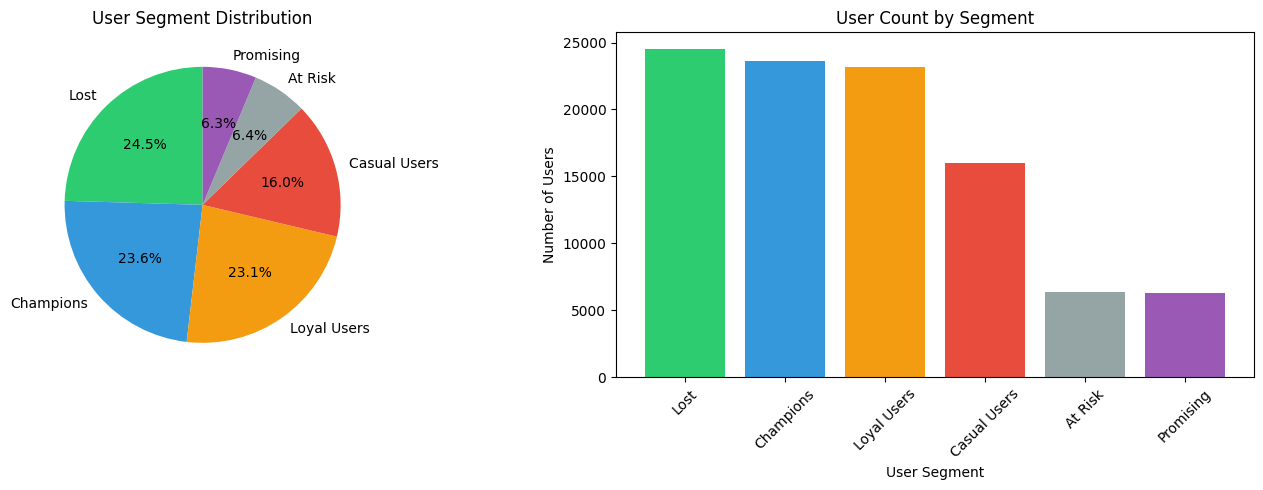

In [17]:
# Visualize RFM segments
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to Pandas for visualization
segment_viz = segment_pct.select("UserSegment", "UserCount", "Percentage").toPandas()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
colors = ['#2ecc71', '#3498db', '#f39c12', '#e74c3c', '#95a5a6', '#9b59b6']
ax1.pie(segment_viz["UserCount"], labels=segment_viz["UserSegment"], autopct='%1.1f%%',
        colors=colors, startangle=90)
ax1.set_title("User Segment Distribution")

# Bar chart
ax2.bar(segment_viz["UserSegment"], segment_viz["UserCount"], color=colors)
ax2.set_xlabel("User Segment")
ax2.set_ylabel("Number of Users")
ax2.set_title("User Count by Segment")
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [18]:
# Export RFM user segmentation data for Tableau
print("\n=== Exporting RFM Segmentation Data ===")

# Export detailed RFM scores for each user
rfm_export = rfm_segmented.select(
    "UserId", "Recency", "Frequency", "Monetary",
    "R_Score", "F_Score", "M_Score", "RFM_Score", "UserSegment"
)
rfm_export.coalesce(1).write.mode('overwrite').csv(
    "tableau_exports/rfm_user_segments.csv", header=True
)
print("✓ Exported: rfm_user_segments.csv")

# Export segment summary statistics
segment_summary = segment_pct.select(
    "UserSegment", "UserCount", "Percentage", 
    "AvgRecency", "AvgFrequency", "AvgMonetary"
)
segment_summary.coalesce(1).write.mode('overwrite').csv(
    "tableau_exports/rfm_segment_summary.csv", header=True
)
print("✓ Exported: rfm_segment_summary.csv")


=== Exporting RFM Segmentation Data ===
✓ Exported: rfm_user_segments.csv
✓ Exported: rfm_segment_summary.csv


### 5.3. Temporal Activity Patterns (Heatmap Analysis)

Understanding when users are most active helps optimize content scheduling and resource allocation. This analysis uses modulo arithmetic on relative time to identify daily and weekly patterns.

In [19]:
# Temporal pattern analysis using relative time
from pyspark.sql.functions import hour, dayofweek

# Calculate hour of day and day of week using modulo arithmetic
# Hour of day: 0-23
# Day of week: 0-6 (where 0 = first day in dataset)
temporal_df = spark_df.withColumn(
    "HourOfDay", ((col("StartTime") % 1440) / 60).cast("int")
).withColumn(
    "DayOfWeek", ((col("StartTime") / 1440).cast("int") % 7)
)

# User activity by hour and day of week
hourly_weekly_activity = temporal_df.groupBy("DayOfWeek", "HourOfDay").agg(
    countDistinct("UserId").alias("UniqueUsers"),
    count("*").alias("TotalInteractions")
).orderBy("DayOfWeek", "HourOfDay")

print("=== Sample of Hourly-Weekly Activity ===")
hourly_weekly_activity.show(10)

# Peak hours analysis
peak_hours = temporal_df.groupBy("HourOfDay").agg(
    countDistinct("UserId").alias("UniqueUsers"),
    count("*").alias("TotalInteractions")
).orderBy(col("UniqueUsers").desc())

print("\n=== Top 10 Peak Hours ===")
peak_hours.show(10)

# Day of week analysis
dow_activity = temporal_df.groupBy("DayOfWeek").agg(
    countDistinct("UserId").alias("UniqueUsers" ),
    count("*").alias("TotalInteractions"),
    avg(col("StopTime") - col("StartTime")).alias("AvgWatchDuration")
).orderBy("DayOfWeek")

print("\n=== Activity by Day of Week ===")
dow_activity.show()

=== Sample of Hourly-Weekly Activity ===


+---------+---------+-----------+-----------------+
|DayOfWeek|HourOfDay|UniqueUsers|TotalInteractions|
+---------+---------+-----------+-----------------+
|        0|        0|      21973|            38348|
|        0|        1|      14056|            22571|
|        0|        2|      21171|            35490|
|        0|        3|      13452|            20963|
|        0|        4|      20166|            33439|
|        0|        5|      16189|            26681|
|        0|        6|      14709|            23124|
|        0|        7|      19590|            32032|
|        0|        8|      13817|            21470|
|        0|        9|      19852|            32697|
+---------+---------+-----------+-----------------+
only showing top 10 rows

=== Top 10 Peak Hours ===


+---------+-----------+-----------------+
|HourOfDay|UniqueUsers|TotalInteractions|
+---------+-----------+-----------------+
|        4|      60945|           194806|
|        2|      57383|           175995|
|       23|      54493|           158212|
|       16|      54398|           156897|
|       21|      52553|           145362|
|        9|      52018|           142533|
|       18|      50648|           141652|
|       14|      50444|           137293|
|       11|      50324|           135815|
|        0|      49672|           145774|
+---------+-----------+-----------------+
only showing top 10 rows

=== Activity by Day of Week ===


+---------+-----------+-----------------+------------------+
|DayOfWeek|UniqueUsers|TotalInteractions|  AvgWatchDuration|
+---------+-----------+-----------------+------------------+
|        0|      78190|           670158|2.9203038686399325|
|        1|      82502|           703002| 3.079634197342255|
|        2|      83358|           737847|3.3704467186286586|
|        3|      82743|           743555| 3.073737652224785|
|        4|      53147|           197171|3.5212581971993853|
+---------+-----------+-----------------+------------------+



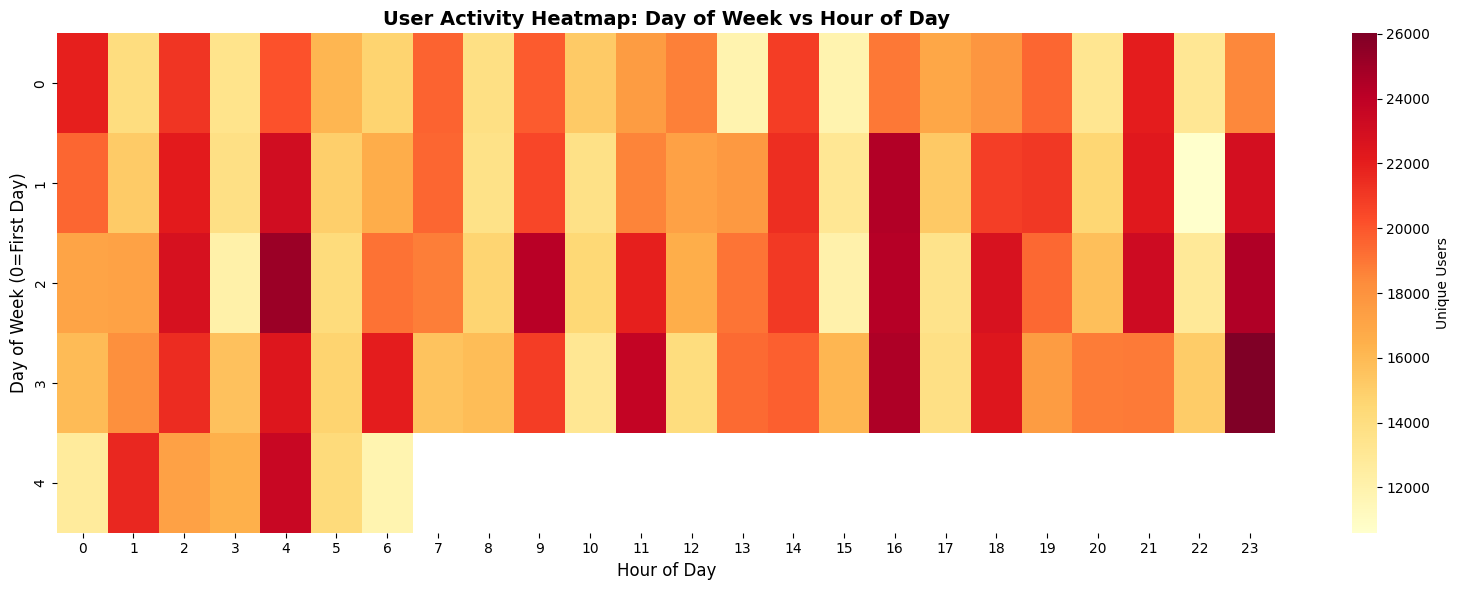

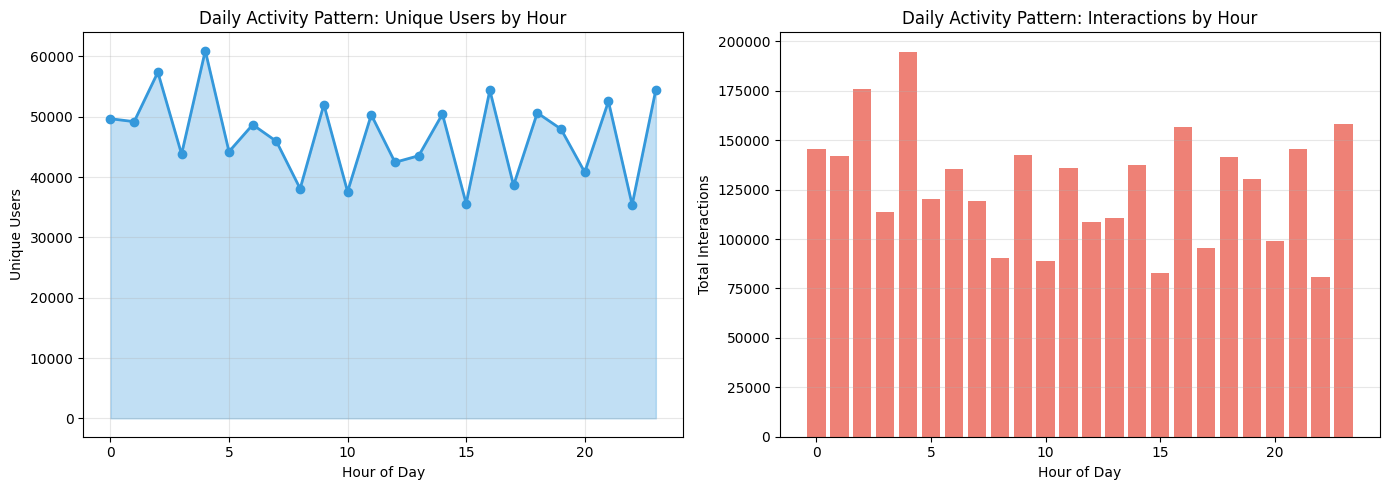

In [20]:
# Create heatmap visualization
import numpy as np

# Convert to Pandas and pivot for heatmap
heatmap_data = hourly_weekly_activity.toPandas()
heatmap_pivot = heatmap_data.pivot(index="DayOfWeek", columns="HourOfDay", values="UniqueUsers")

# Create heatmap
fig, ax = plt.subplots(figsize=(16, 6))
sns.heatmap(heatmap_pivot, cmap="YlOrRd", annot=False, fmt="d", cbar_kws={'label': 'Unique Users'}, ax=ax)
ax.set_title("User Activity Heatmap: Day of Week vs Hour of Day", fontsize=14, fontweight='bold')
ax.set_xlabel("Hour of Day", fontsize=12)
ax.set_ylabel("Day of Week (0=First Day)", fontsize=12)
plt.tight_layout()
plt.show()

# Hourly pattern visualization
peak_hours_pd = peak_hours.toPandas()
peak_hours_pd_sorted = peak_hours_pd.sort_values(by="HourOfDay")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Unique users by hour
ax1.plot(peak_hours_pd_sorted["HourOfDay"], peak_hours_pd_sorted["UniqueUsers"], marker='o', linewidth=2, color='#3498db')
ax1.fill_between(peak_hours_pd_sorted["HourOfDay"], peak_hours_pd_sorted["UniqueUsers"], alpha=0.3, color='#3498db')
ax1.set_xlabel("Hour of Day")
ax1.set_ylabel("Unique Users")
ax1.set_title("Daily Activity Pattern: Unique Users by Hour")
ax1.grid(True, alpha=0.3)

# Total interactions by hour
ax2.bar(peak_hours_pd["HourOfDay"], peak_hours_pd["TotalInteractions"], color='#e74c3c', alpha=0.7)
ax2.set_xlabel("Hour of Day")
ax2.set_ylabel("Total Interactions")
ax2.set_title("Daily Activity Pattern: Interactions by Hour")
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [21]:
# Export temporal activity data for Tableau
print("\n=== Exporting Temporal Activity Data ===")

# Export hourly-weekly activity matrix
hourly_weekly_export = hourly_weekly_activity.select(
    "DayOfWeek", "HourOfDay", "UniqueUsers", "TotalInteractions"
)
hourly_weekly_export.coalesce(1).write.mode('overwrite').csv(
    "tableau_exports/hourly_weekly_activity.csv", header=True
)
print("✓ Exported: hourly_weekly_activity.csv")

# Export peak hours summary
peak_hours_export = peak_hours.select("HourOfDay", "UniqueUsers", "TotalInteractions")
peak_hours_export.coalesce(1).write.mode('overwrite').csv(
    "tableau_exports/peak_hours.csv", header=True
)
print("✓ Exported: peak_hours.csv")

# Export day of week summary
dow_export = dow_activity.select("DayOfWeek", "UniqueUsers", "TotalInteractions", "AvgWatchDuration")
dow_export.coalesce(1).write.mode('overwrite').csv(
    "tableau_exports/day_of_week_activity.csv", header=True
)
print("✓ Exported: day_of_week_activity.csv")


=== Exporting Temporal Activity Data ===


✓ Exported: hourly_weekly_activity.csv


✓ Exported: peak_hours.csv
✓ Exported: day_of_week_activity.csv


### 5.4. Statistical Analysis: Correlation and Regression

Moving beyond descriptive statistics, we now test hypotheses about relationships between variables using statistical tests and regression models.

In [22]:
# Statistical Analysis: Correlation and Regression
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Hypothesis: Does streamer activity (stream count) correlate with audience size?
streamer_stats_analysis = spark_df.groupBy("Streamer").agg(
    countDistinct("StreamID").alias("StreamCount"),
    countDistinct("UserId").alias("UniqueWatchers"),
    avg(col("StopTime") - col("StartTime")).alias("AvgWatchDuration"),
    spark_sum(col("StopTime") - col("StartTime")).alias("TotalWatchTime")
)

stats_pd = streamer_stats_analysis.toPandas()

# Remove outliers for cleaner analysis (top 1% and bottom 1%)
q_low = stats_pd["StreamCount"].quantile(0.01)
q_high = stats_pd["StreamCount"].quantile(0.99)
stats_filtered = stats_pd[(stats_pd["StreamCount"] >= q_low) & (stats_pd["StreamCount"] <= q_high)]

print("=== Correlation Analysis: Streamer Metrics ===")
print(f"Dataset size: {len(stats_filtered)} streamers (after removing outliers)")

# 1. Pearson correlation (linear relationship)
corr_streams_watchers, p_val_sw = pearsonr(stats_filtered["StreamCount"], stats_filtered["UniqueWatchers"])
print(f"\nStream Count vs Unique Watchers:")
print(f"  Pearson r = {corr_streams_watchers:.4f}, p-value = {p_val_sw:.2e}")
print(f"  Interpretation: {'Significant' if p_val_sw < 0.05 else 'Not significant'} correlation")

# 2. Spearman correlation (monotonic relationship, robust to outliers)
corr_spearman, p_val_spearman = spearmanr(stats_filtered["StreamCount"], stats_filtered["UniqueWatchers"])
print(f"  Spearman ρ = {corr_spearman:.4f}, p-value = {p_val_spearman:.2e}")

# 3. Stream Count vs Average Watch Duration
corr_duration, p_val_dur = pearsonr(stats_filtered["StreamCount"], stats_filtered["AvgWatchDuration"])
print(f"\nStream Count vs Avg Watch Duration:")
print(f"  Pearson r = {corr_duration:.4f}, p-value = {p_val_dur:.2e}")
print(f"  Interpretation: {'Significant' if p_val_dur < 0.05 else 'Not significant'} correlation")

# Linear Regression: Predict Unique Watchers from Stream Count
X = stats_filtered[["StreamCount"]].values
y = stats_filtered["UniqueWatchers"].values

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print(f"\n=== Linear Regression Model ===")
print(f"Model: UniqueWatchers = {model.intercept_:.2f} + {model.coef_[0]:.4f} * StreamCount")
print(f"R² Score: {r2:.4f} ({r2*100:.2f}% of variance explained)")
print(f"RMSE: {rmse:.2f}")
print(f"\nInterpretation:")
print(f"  For each additional stream, a streamer gains approximately {model.coef_[0]:.2f} unique watchers on average.")

=== Correlation Analysis: Streamer Metrics ===
Dataset size: 161126 streamers (after removing outliers)

Stream Count vs Unique Watchers:
  Pearson r = 0.2244, p-value = 0.00e+00
  Interpretation: Significant correlation
  Spearman ρ = 0.8158, p-value = 0.00e+00

Stream Count vs Avg Watch Duration:
  Pearson r = 0.0933, p-value = 4.04e-308
  Interpretation: Significant correlation

=== Linear Regression Model ===
Model: UniqueWatchers = -5.57 + 3.0830 * StreamCount
R² Score: 0.0504 (5.04% of variance explained)
RMSE: 81.62

Interpretation:
  For each additional stream, a streamer gains approximately 3.08 unique watchers on average.


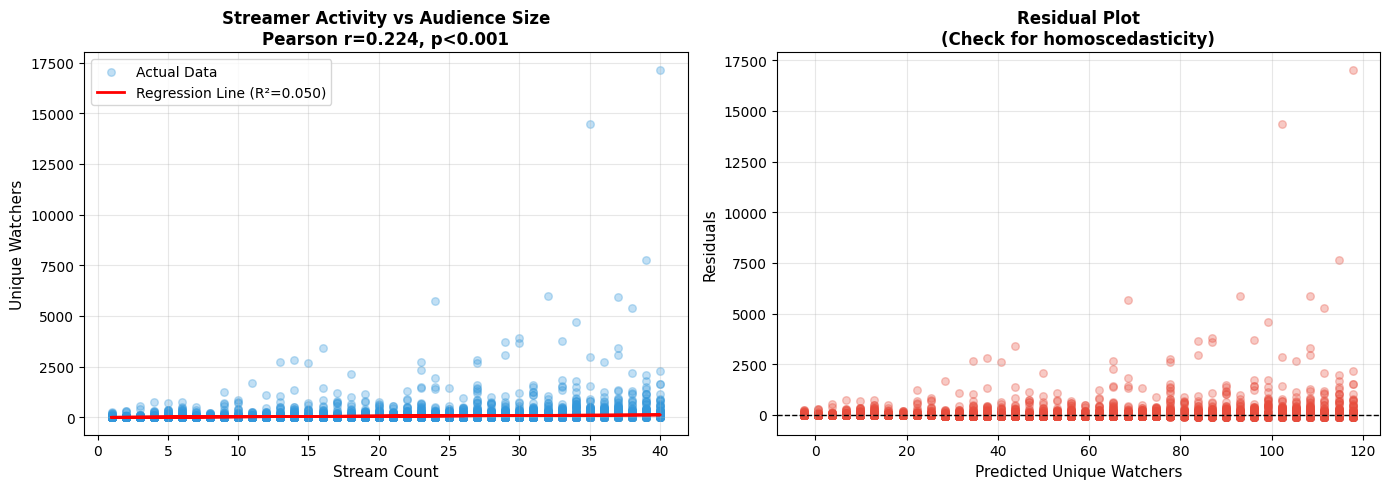

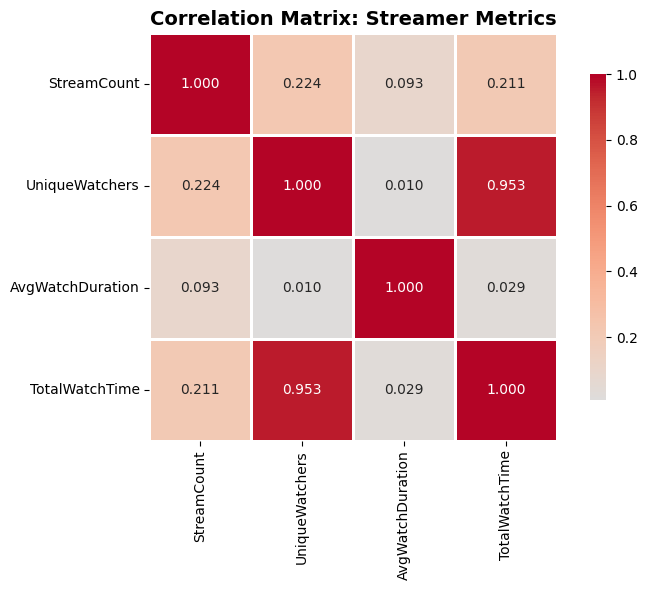

In [23]:
# Visualize regression results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot with regression line
ax1.scatter(stats_filtered["StreamCount"], stats_filtered["UniqueWatchers"], 
            alpha=0.3, s=30, color='#3498db', label='Actual Data')
ax1.plot(stats_filtered["StreamCount"], y_pred, color='red', linewidth=2, 
         label=f'Regression Line (R²={r2:.3f})')
ax1.set_xlabel("Stream Count", fontsize=11)
ax1.set_ylabel("Unique Watchers", fontsize=11)
ax1.set_title(f"Streamer Activity vs Audience Size\nPearson r={corr_streams_watchers:.3f}, p<0.001", 
              fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Residual plot
residuals = y - y_pred
ax2.scatter(y_pred, residuals, alpha=0.3, s=30, color='#e74c3c')
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax2.set_xlabel("Predicted Unique Watchers", fontsize=11)
ax2.set_ylabel("Residuals", fontsize=11)
ax2.set_title("Residual Plot\n(Check for homoscedasticity)", fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Correlation matrix heatmap
corr_matrix = stats_filtered[["StreamCount", "UniqueWatchers", "AvgWatchDuration", "TotalWatchTime"]].corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".3f", cmap="coolwarm", center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title("Correlation Matrix: Streamer Metrics", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [24]:
# Export correlation and regression analysis data for Tableau
print("\n=== Exporting Statistical Analysis Data ===")

# Export streamer statistics with correlations
stats_export = stats_filtered[["StreamCount", "UniqueWatchers", "AvgWatchDuration", "TotalWatchTime"]].copy()
stats_export['PredictedWatchers'] = y_pred
stats_export['Residuals'] = residuals
stats_export.to_csv("tableau_exports/streamer_correlation_analysis.csv", index=False)
print("✓ Exported: streamer_correlation_analysis.csv")

# Export correlation matrix
corr_matrix_export = corr_matrix.reset_index()
corr_matrix_export.to_csv("tableau_exports/correlation_matrix.csv", index=False)
print("✓ Exported: correlation_matrix.csv")


=== Exporting Statistical Analysis Data ===
✓ Exported: streamer_correlation_analysis.csv
✓ Exported: correlation_matrix.csv


### 5.5. Content Health Metrics

Beyond basic statistics, we need composite metrics to assess the overall health of the content ecosystem.

#### 5.5.1. Streamer Health Score

A multi-dimensional score combining audience size, engagement quality, and consistency.

In [25]:
# Streamer Health Score - Optimized for Big Data
# Combines: audience size, engagement (watch duration), activity consistency
from pyspark.sql.functions import concat, lit   

# Calculate streamer metrics including temporal spread
streamer_health_metrics = spark_df.groupBy("Streamer").agg(
    countDistinct("UserId").alias("UniqueViewers"),
    countDistinct("StreamID").alias("StreamCount"),
    avg(col("StopTime") - col("StartTime")).alias("AvgWatchDuration"),
    spark_sum(col("StopTime") - col("StartTime")).alias("TotalWatchTime"),
    countDistinct((col("StartTime") / 1440).cast("int")).alias("ActiveDays"),
    (spark_max("StopTime") - spark_min("StartTime")).alias("TimeSpan")
)

# Calculate derived metrics
streamer_health = streamer_health_metrics.withColumn(
    "ViewersPerStream", col("UniqueViewers") / col("StreamCount")
).withColumn(
    "Consistency", col("StreamCount") / (col("TimeSpan") / 1440 + 1)  # Streams per day
)

# Big Data Optimization: Use approxQuantile for percentile-based scoring
# This avoids global sorting with Window functions and enables partition-level parallelism
print("=== Computing Streamer Score Thresholds (Optimized) ===")

# Use finer granularity: percentiles at every 1% (1, 2, 3, ..., 99) for better distribution
# This gives us 100 scoring buckets instead of just 10
percentile_points = [i/100.0 for i in range(1, 100)]

viewers_percentiles = streamer_health.approxQuantile("UniqueViewers", percentile_points, 0.01)
duration_percentiles = streamer_health.approxQuantile("AvgWatchDuration", percentile_points, 0.01)
consistency_percentiles = streamer_health.approxQuantile("Consistency", percentile_points, 0.01)

print(f"Sample UniqueViewers percentiles (10th, 25th, 50th, 75th, 90th):")
print(f"  [P10={viewers_percentiles[9]}, P25={viewers_percentiles[24]}, " + 
      f"P50={viewers_percentiles[49]}, P75={viewers_percentiles[74]}, P90={viewers_percentiles[89]}]")

# Helper function to create score column (1-100 scale) using percentile ranking
def create_percentile_score(col_name, percentiles):
    """
    Create a score (1-100 scale) based on fine-grained percentile thresholds.
    Uses cascading when() conditions to map values to their percentile rank.
    
    For values with many duplicates at boundaries, all duplicates will be assigned
    to the same percentile bucket, which is the correct behavior.
    """
    # Start with score=1 for values <= 1st percentile
    score_expr = when(col(col_name) <= percentiles[0], 1)
    
    # Add conditions for percentiles 2-99 (scores 2-99)
    for i in range(1, len(percentiles)):
        score_expr = score_expr.when(col(col_name) <= percentiles[i], i + 1)
    
    # Values > 99th percentile get score=100
    return score_expr.otherwise(100)

# Apply scoring using percentile thresholds (fully parallelizable across partitions)
streamer_scored = streamer_health \
    .withColumn("AudienceScore", create_percentile_score("UniqueViewers", viewers_percentiles)) \
    .withColumn("EngagementScore", create_percentile_score("AvgWatchDuration", duration_percentiles)) \
    .withColumn("ConsistencyScore", create_percentile_score("Consistency", consistency_percentiles))

# Calculate composite health score (weighted average)
streamer_scored = streamer_scored.withColumn(
    "HealthScore",
    (col("AudienceScore") * 0.4 + 
     col("EngagementScore") * 0.3 + 
     col("ConsistencyScore") * 0.3).cast("int")
)

# Classify streamers by tier
streamer_classified = streamer_scored.withColumn("Tier",
    when(col("HealthScore") >= 80, "S-Tier (Top)")
    .when(col("HealthScore") >= 60, "A-Tier (High)")
    .when(col("HealthScore") >= 40, "B-Tier (Mid)")
    .when(col("HealthScore") >= 20, "C-Tier (Low)")
    .otherwise("D-Tier (Struggling)")
)

print("\n=== Streamer Tier Distribution ===")
tier_dist = streamer_classified.groupBy("Tier").agg(
    count("*").alias("StreamerCount"),
    avg("UniqueViewers").alias("AvgViewers"),
    avg("AvgWatchDuration").alias("AvgDuration"),
    avg("StreamCount").alias("AvgStreams")
).orderBy(col("StreamerCount").desc())

tier_dist.show()

# Calculate percentage distribution
total_streamers = streamer_classified.count()
tier_pct = tier_dist.withColumn("Percentage", 
    (col("StreamerCount") / total_streamers * 100).cast("decimal(5,2)"))
print("\n=== Tier Percentage Distribution ===")
tier_pct.select("Tier", "StreamerCount", "Percentage").orderBy(col("Tier").desc()).show()

# Show score distribution to verify
print("\n=== Score Distribution Verification ===")
streamer_classified.select(
    avg("AudienceScore").alias("AvgAudienceScore"),
    avg("EngagementScore").alias("AvgEngagementScore"),
    avg("ConsistencyScore").alias("AvgConsistencyScore"),
    avg("HealthScore").alias("AvgHealthScore")
).show()

# Top performing streamers
print("\n=== Top 20 Healthiest Streamers ===")
streamer_classified.orderBy(col("HealthScore").desc()) \
    .select("Streamer", "Tier", "HealthScore", "AudienceScore", "EngagementScore", "ConsistencyScore",
            "UniqueViewers", "AvgWatchDuration", "Consistency") \
    .show(20, truncate=False)

# Show HealthScore distribution across different ranges
print("\n=== HealthScore Distribution (Histogram) ===")
streamer_classified.groupBy(
    (col("HealthScore") / 10).cast("int").alias("ScoreBucket")
).agg(
    count("*").alias("Count")
).withColumn(
    "Range", 
    concat(col("ScoreBucket") * 10, lit("-"), (col("ScoreBucket") + 1) * 10)
).select("Range", "Count").orderBy("ScoreBucket").show()

# Bottom performers for comparison
print("\n=== Bottom 10 Streamers (for comparison) ===")
streamer_classified.orderBy(col("HealthScore").asc()) \
    .select("Streamer", "Tier", "HealthScore", "AudienceScore", "EngagementScore", "ConsistencyScore") \
    .show(10, truncate=False)

=== Computing Streamer Score Thresholds (Optimized) ===


Sample UniqueViewers percentiles (10th, 25th, 50th, 75th, 90th):
  [P10=1.0, P25=1.0, P50=1.0, P75=3.0, P90=8.0]

=== Streamer Tier Distribution ===


+-------------------+-------------+------------------+------------------+------------------+
|               Tier|StreamerCount|        AvgViewers|       AvgDuration|        AvgStreams|
+-------------------+-------------+------------------+------------------+------------------+
|D-Tier (Struggling)|        45321|               1.0|1.0167519839956458| 1.069261490258379|
|       C-Tier (Low)|        44208| 1.204125950054289| 3.585871913442151|1.4349665218964893|
|      A-Tier (High)|        26923| 4.992237120677488| 2.859561245738202| 5.870891059688742|
|       B-Tier (Mid)|        26206|2.2444096771731665| 3.193043592835955|3.0642600931084485|
|       S-Tier (Top)|        19967|60.769369459608356|3.6699539774541847|19.518705864676715|
+-------------------+-------------+------------------+------------------+------------------+




=== Tier Percentage Distribution ===


+-------------------+-------------+----------+
|               Tier|StreamerCount|Percentage|
+-------------------+-------------+----------+
|       S-Tier (Top)|        19967|     12.28|
|D-Tier (Struggling)|        45321|     27.87|
|       C-Tier (Low)|        44208|     27.18|
|       B-Tier (Mid)|        26206|     16.11|
|      A-Tier (High)|        26923|     16.56|
+-------------------+-------------+----------+


=== Score Distribution Verification ===


+-----------------+------------------+-------------------+------------------+
| AvgAudienceScore|AvgEngagementScore|AvgConsistencyScore|    AvgHealthScore|
+-----------------+------------------+-------------------+------------------+
|34.14934358186011| 44.17162797847809|  46.97933897002306|40.589903151421986|
+-----------------+------------------+-------------------+------------------+


=== Top 20 Healthiest Streamers ===


+------------------+------------+-----------+-------------+---------------+----------------+-------------+------------------+------------------+
|Streamer          |Tier        |HealthScore|AudienceScore|EngagementScore|ConsistencyScore|UniqueViewers|AvgWatchDuration  |Consistency       |
+------------------+------------+-----------+-------------+---------------+----------------+-------------+------------------+------------------+
|mrmacavity        |S-Tier (Top)|99         |99           |99             |99              |50           |9.024793388429751 |5.576923076923077 |
|halieatisuto      |S-Tier (Top)|99         |99           |99             |99              |97           |11.721311475409836|7.353850288939658 |
|bloodyhs          |S-Tier (Top)|98         |99           |96             |99              |53           |7.21505376344086  |5.58214142494319  |
|kabeosyama        |S-Tier (Top)|98         |99           |97             |99              |68           |7.617801047120419 |5.940

+------+-----+
| Range|Count|
+------+-----+
|  0-10|  883|
| 10-20|44438|
| 20-30|23503|
| 30-40|20705|
| 40-50|14109|
| 50-60|12097|
| 60-70|11935|
| 70-80|14988|
| 80-90|14557|
|90-100| 5410|
+------+-----+


=== Bottom 10 Streamers (for comparison) ===


+---------------+-------------------+-----------+-------------+---------------+----------------+
|Streamer       |Tier               |HealthScore|AudienceScore|EngagementScore|ConsistencyScore|
+---------------+-------------------+-----------+-------------+---------------+----------------+
|reedopk        |D-Tier (Struggling)|1          |1            |1              |2               |
|spyroo15       |D-Tier (Struggling)|1          |1            |1              |3               |
|lisadorina     |D-Tier (Struggling)|1          |1            |1              |3               |
|itsthatguy7100 |D-Tier (Struggling)|1          |1            |1              |2               |
|postalhollywood|D-Tier (Struggling)|1          |1            |1              |2               |
|akmcbride      |D-Tier (Struggling)|1          |1            |1              |3               |
|tastethewaffle |D-Tier (Struggling)|1          |1            |1              |3               |
|gintomic       |D-Tier (Strug

In [26]:
# Export streamer health score data for Tableau
print("\n=== Exporting Streamer Health Score Data ===")

# Export detailed health scores for all streamers
health_export = streamer_classified.select(
    "Streamer", "Tier", "HealthScore", 
    "UniqueViewers", "StreamCount", "AvgWatchDuration",
    "AudienceScore", "EngagementScore", "ConsistencyScore",
    "Consistency", "ActiveDays"
)
health_export.coalesce(1).write.mode('overwrite').csv(
    "tableau_exports/streamer_health_scores.csv", header=True
)
print("✓ Exported: streamer_health_scores.csv")

# Export tier distribution summary
tier_export = tier_dist.select(
    "Tier", "StreamerCount", "AvgViewers", "AvgDuration", "AvgStreams"
)
tier_export.coalesce(1).write.mode('overwrite').csv(
    "tableau_exports/streamer_tier_distribution.csv", header=True
)
print("✓ Exported: streamer_tier_distribution.csv")


=== Exporting Streamer Health Score Data ===


✓ Exported: streamer_health_scores.csv


✓ Exported: streamer_tier_distribution.csv


#### 5.5.2. User Loyalty: Repeat Viewing Analysis

Measures how often users return to watch the same streamer, indicating content quality and fan loyalty.

In [27]:
# Repeat viewing analysis
user_streamer_interactions = spark_df.groupBy("UserId", "Streamer").agg(
    count("*").alias("ViewCount")
)

# Classify viewing behavior
repeat_analysis = user_streamer_interactions.withColumn("ViewerType",
    when(col("ViewCount") == 1, "One-time")
    .when(col("ViewCount").between(2, 5), "Casual")
    .when(col("ViewCount").between(6, 15), "Regular")
    .otherwise("Superfan")
)

print("=== User Loyalty Distribution ===")
loyalty_dist = repeat_analysis.groupBy("ViewerType").agg(
    count("*").alias("Count")
).orderBy(col("Count").desc())
loyalty_dist.show()

# Calculate repeat view rate
total_user_streamer_pairs = repeat_analysis.count()
repeat_viewers = repeat_analysis.filter(col("ViewCount") > 1).count()
repeat_rate = repeat_viewers / total_user_streamer_pairs * 100

print(f"\n=== Overall Repeat View Metrics ===")
print(f"Total User-Streamer Pairs: {total_user_streamer_pairs:,}")
print(f"Pairs with Repeat Views: {repeat_viewers:,}")
print(f"Repeat View Rate: {repeat_rate:.2f}%")

# Streamers with highest loyalty (most superfans)
print("\n=== Streamers with Most Loyal Fans ===")
loyal_fans_per_streamer = repeat_analysis.filter(col("ViewerType") == "Superfan") \
    .groupBy("Streamer").agg(count("*").alias("SuperfanCount")) \
    .orderBy(col("SuperfanCount").desc())

loyal_fans_per_streamer.show(15, truncate=False)

# Average views per user-streamer relationship
avg_views_per_relationship = user_streamer_interactions.select(avg("ViewCount")).collect()[0][0]
print(f"\nAverage views per user-streamer relationship: {avg_views_per_relationship:.2f}")

=== User Loyalty Distribution ===


+----------+------+
|ViewerType| Count|
+----------+------+
|  One-time|957261|
|    Casual|451259|
|   Regular| 93061|
|  Superfan|  3577|
+----------+------+




=== Overall Repeat View Metrics ===
Total User-Streamer Pairs: 1,505,158
Pairs with Repeat Views: 547,897
Repeat View Rate: 36.40%

=== Streamers with Most Loyal Fans ===


+----------------+-------------+
|Streamer        |SuperfanCount|
+----------------+-------------+
|noway4u_sir     |120          |
|moonmoon_ow     |71           |
|pow3rtv         |61           |
|chocotaco       |49           |
|admiralbulldog  |44           |
|mobilmobil      |41           |
|cohhcarnage     |40           |
|gotaga          |39           |
|pajalockk       |38           |
|armatvhs        |36           |
|ninja           |35           |
|dakotaz         |31           |
|officialandypyro|31           |
|solary          |30           |
|xqcow           |28           |
+----------------+-------------+
only showing top 15 rows



Average views per user-streamer relationship: 2.03


In [28]:
# Export user loyalty data for Tableau
print("\n=== Exporting User Loyalty Data ===")

# Export user-streamer interaction counts with loyalty classification
loyalty_export = repeat_analysis.select("UserId", "Streamer", "ViewCount", "ViewerType")
loyalty_export.coalesce(1).write.mode('overwrite').csv(
    "tableau_exports/user_loyalty_detail.csv", header=True
)
print("✓ Exported: user_loyalty_detail.csv")

# Export loyalty distribution summary
loyalty_summary = loyalty_dist.select("ViewerType", "Count")
loyalty_summary.coalesce(1).write.mode('overwrite').csv(
    "tableau_exports/loyalty_distribution.csv", header=True
)
print("✓ Exported: loyalty_distribution.csv")

# Export streamer superfan rankings
superfan_export = loyal_fans_per_streamer.select("Streamer", "SuperfanCount")
superfan_export.coalesce(1).write.mode('overwrite').csv(
    "tableau_exports/streamer_superfans.csv", header=True
)
print("✓ Exported: streamer_superfans.csv")


=== Exporting User Loyalty Data ===


✓ Exported: user_loyalty_detail.csv


✓ Exported: loyalty_distribution.csv


✓ Exported: streamer_superfans.csv


#### 5.5.3. Long-Tail Effect Quantification (Gini Coefficient)

The Gini coefficient measures inequality in the distribution of viewers across streamers. A higher value indicates stronger concentration of viewership among top streamers.

=== Inequality Metrics (Gini Coefficient) ===
Gini Coefficient for Streamer Popularity: 0.8315
Interpretation: High inequality
  0 = Perfect equality, 1 = Maximum inequality

=== Viewer Concentration Analysis ===
Top 1% of streamers (1,626 streamers) attract: 52.50% of viewers
Top 5% of streamers (8,131 streamers) attract: 73.66% of viewers
Top 10% of streamers (16,262 streamers) attract: 81.13% of viewers
Top 20% of streamers (32,525 streamers) attract: 87.48% of viewers


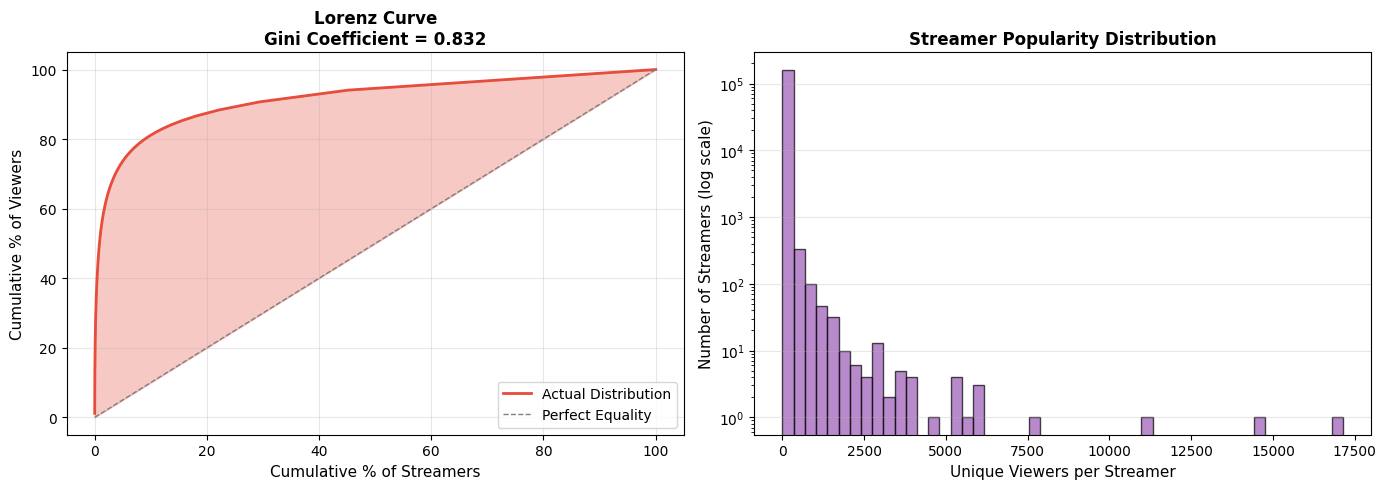

In [29]:
# Calculate Gini Coefficient for viewer distribution
def calculate_gini(values):
    """Calculate Gini coefficient from a sorted array of values"""
    sorted_values = np.sort(values)
    n = len(sorted_values)
    cumsum = np.cumsum(sorted_values)
    return (2 * np.sum((np.arange(1, n+1)) * sorted_values)) / (n * cumsum[-1]) - (n + 1) / n

# Viewer distribution across streamers
streamer_viewers = spark_df.groupBy("Streamer").agg(
    countDistinct("UserId").alias("ViewerCount")
).toPandas()

gini_streamers = calculate_gini(streamer_viewers["ViewerCount"].values)

print("=== Inequality Metrics (Gini Coefficient) ===")
print(f"Gini Coefficient for Streamer Popularity: {gini_streamers:.4f}")
print(f"Interpretation: {'High' if gini_streamers > 0.6 else 'Moderate' if gini_streamers > 0.4 else 'Low'} inequality")
print(f"  0 = Perfect equality, 1 = Maximum inequality")

# Calculate viewer concentration (what % of viewers watch top X% of streamers)
streamer_viewers_sorted = streamer_viewers.sort_values("ViewerCount", ascending=False)
streamer_viewers_sorted["CumulativeViewers"] = streamer_viewers_sorted["ViewerCount"].cumsum()
total_viewer_interactions = streamer_viewers_sorted["ViewerCount"].sum()

# Top percentiles
top_1_pct = int(len(streamer_viewers_sorted) * 0.01)
top_5_pct = int(len(streamer_viewers_sorted) * 0.05)
top_10_pct = int(len(streamer_viewers_sorted) * 0.10)
top_20_pct = int(len(streamer_viewers_sorted) * 0.20)

concentration_1 = streamer_viewers_sorted.iloc[:top_1_pct]["ViewerCount"].sum() / total_viewer_interactions * 100
concentration_5 = streamer_viewers_sorted.iloc[:top_5_pct]["ViewerCount"].sum() / total_viewer_interactions * 100
concentration_10 = streamer_viewers_sorted.iloc[:top_10_pct]["ViewerCount"].sum() / total_viewer_interactions * 100
concentration_20 = streamer_viewers_sorted.iloc[:top_20_pct]["ViewerCount"].sum() / total_viewer_interactions * 100

print(f"\n=== Viewer Concentration Analysis ===")
print(f"Top 1% of streamers ({top_1_pct:,} streamers) attract: {concentration_1:.2f}% of viewers")
print(f"Top 5% of streamers ({top_5_pct:,} streamers) attract: {concentration_5:.2f}% of viewers")
print(f"Top 10% of streamers ({top_10_pct:,} streamers) attract: {concentration_10:.2f}% of viewers")
print(f"Top 20% of streamers ({top_20_pct:,} streamers) attract: {concentration_20:.2f}% of viewers")

# Lorenz curve visualization
streamer_viewers_sorted["CumulativeStreamerPct"] = np.arange(1, len(streamer_viewers_sorted)+1) / len(streamer_viewers_sorted) * 100
streamer_viewers_sorted["CumulativeViewerPct"] = streamer_viewers_sorted["CumulativeViewers"] / total_viewer_interactions * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Lorenz Curve
ax1.plot(streamer_viewers_sorted["CumulativeStreamerPct"], 
         streamer_viewers_sorted["CumulativeViewerPct"], 
         linewidth=2, label='Actual Distribution', color='#e74c3c')
ax1.plot([0, 100], [0, 100], '--', linewidth=1, label='Perfect Equality', color='gray')
ax1.fill_between(streamer_viewers_sorted["CumulativeStreamerPct"], 
                  streamer_viewers_sorted["CumulativeViewerPct"], 
                  streamer_viewers_sorted["CumulativeStreamerPct"], 
                  alpha=0.3, color='#e74c3c')
ax1.set_xlabel("Cumulative % of Streamers", fontsize=11)
ax1.set_ylabel("Cumulative % of Viewers", fontsize=11)
ax1.set_title(f"Lorenz Curve\nGini Coefficient = {gini_streamers:.3f}", fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Viewer distribution histogram (log scale)
ax2.hist(streamer_viewers["ViewerCount"], bins=50, color='#9b59b6', edgecolor='black', alpha=0.7)
ax2.set_xlabel("Unique Viewers per Streamer", fontsize=11)
ax2.set_ylabel("Number of Streamers (log scale)", fontsize=11)
ax2.set_title("Streamer Popularity Distribution", fontsize=12, fontweight='bold')
ax2.set_yscale("log")
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [30]:
# Export Gini coefficient and inequality data for Tableau
print("\n=== Exporting Inequality Analysis Data ===")

# Export viewer distribution per streamer
streamer_viewers.to_csv("tableau_exports/streamer_viewer_distribution.csv", index=False)
print("✓ Exported: streamer_viewer_distribution.csv")

# Export Lorenz curve data
lorenz_export = streamer_viewers_sorted[["CumulativeStreamerPct", "CumulativeViewerPct"]].copy()
lorenz_export.to_csv("tableau_exports/lorenz_curve_data.csv", index=False)
print("✓ Exported: lorenz_curve_data.csv")

# Export concentration metrics
concentration_summary = pd.DataFrame({
    'Percentile': ['Top 1%', 'Top 5%', 'Top 10%', 'Top 20%'],
    'StreamerCount': [top_1_pct, top_5_pct, top_10_pct, top_20_pct],
    'ViewerShare': [concentration_1, concentration_5, concentration_10, concentration_20]
})
concentration_summary.to_csv("tableau_exports/viewer_concentration.csv", index=False)
print("✓ Exported: viewer_concentration.csv")

# Export Gini coefficient as metadata
gini_metadata = pd.DataFrame({
    'Metric': ['Gini Coefficient'],
    'Value': [gini_streamers],
    'Interpretation': ['High' if gini_streamers > 0.6 else 'Moderate' if gini_streamers > 0.4 else 'Low']
})
gini_metadata.to_csv("tableau_exports/gini_coefficient.csv", index=False)
print("✓ Exported: gini_coefficient.csv")


=== Exporting Inequality Analysis Data ===
✓ Exported: streamer_viewer_distribution.csv
✓ Exported: lorenz_curve_data.csv
✓ Exported: viewer_concentration.csv
✓ Exported: gini_coefficient.csv


## 6. Key Insights and Recommendations

Based on the comprehensive analysis of Twitch livestream data, we've uncovered critical patterns in user behavior, content performance, and platform dynamics. This section synthesizes the most actionable insights across five key dimensions.

---

### 6.1 Platform Health Overview

#### 🎯 **Executive Summary**
The platform demonstrates **strong initial engagement** but faces significant challenges in **long-term retention** and **ecosystem inequality**:

| Metric | Value | Assessment |
|--------|-------|------------|
| **Day 1 Retention** | 91.50% | ✅ Excellent |
| **Day 3 Retention** | 64.23% | ⚠️ Moderate decline |
| **Repeat Viewing Rate** | 36.40% | 🔴 Low loyalty |
| **Gini Coefficient** | 0.8315 | 🔴 Extreme inequality |
| **Lost Users** | 24.53% | ⚠️ High churn |
| **Struggling Streamers** | 55.05% (C+D Tier) | 🔴 Critical issue |

---

### 6.2 User Behavior Insights

#### 📊 **6.2.1 Retention Patterns**

**Key Finding**: Users show **exceptional short-term stickiness** but struggle with mid-term engagement.

- **91.50% Day 1 retention** indicates strong onboarding and initial value proposition
- **27% drop to 64.23% by Day 3** suggests engagement degradation after the honeymoon period
- **Day 0 cohort outperforms later cohorts**: First-day users maintain 79.69% retention through Day 3, while Day 1 cohort drops to 9.09% by Day 3

**💡 Recommendation**:
- Implement **Day 2-3 intervention campaigns** (push notifications, personalized recommendations)
- Create **"Second Stream" onboarding flows** to encourage return visits within 48 hours
- Investigate why early adopters (Day 0 cohort) show stronger retention patterns

---

#### 👥 **6.2.2 User Segmentation Analysis**

**Key Finding**: The platform has a **balanced but concerning** user distribution across RFM segments.

| Segment | Size | Characteristics | Strategic Priority |
|---------|------|-----------------|-------------------|
| **Champions** | 23.62% | 72 streams watched, 240 min engagement | 🥇 Retain & reward |
| **Loyal Users** | 23.15% | 29 streams watched, 84 min engagement | 🥈 Upgrade to Champions |
| **Lost Users** | 24.53% | 7 streams, 1,936 min since last activity | 🔴 Win-back campaigns |
| **At Risk** | 6.40% | 40 streams but disengaging | ⚠️ Urgent intervention |
| **Promising** | 6.31% | Recent joiners, low frequency | 🌱 Nurture potential |
| **Casual Users** | 16.00% | 12 streams, irregular engagement | 📈 Conversion opportunity |

**Critical Insight**: **24.53% Lost + 6.40% At Risk = 30.93%** of users are churning or at high risk.

**💡 Recommendations**:
1. **Champions (23.62%)**: 
   - Launch VIP/loyalty program with exclusive perks
   - Enable early access to new features
   - Gather feedback for product improvements

2. **Lost Users (24.53%)**: 
   - Deploy **win-back email campaigns** highlighting new content from previously watched streamers
   - Offer **"Welcome Back" incentives** (bonus channel points, highlighted recommendations)
   - A/B test re-engagement messaging (nostalgia vs. new content)

3. **At Risk (6.40%)**:
   - Trigger **automated retention workflows** when recency exceeds 800 minutes
   - Personalized "We miss you" messages from followed streamers
   - Content diversity recommendations to reignite interest

4. **Promising (6.31%)**:
   - **14-day nurture campaign** with educational content ("How to discover new streamers")
   - Gamification mechanics (watch streaks, achievement badges)
   - Social features to build community connections

---

#### 🔁 **6.2.3 Loyalty Crisis**

**Key Finding**: **63.60% of viewer-streamer relationships are one-time interactions** — a severe loyalty problem.

| Viewer Type | Percentage | Definition |
|-------------|-----------|------------|
| **One-time** | 63.60% | Never return to same streamer |
| **Casual** | 29.98% | 2-5 views of same streamer |
| **Regular** | 6.18% | 6-10 views |
| **Superfan** | 0.24% | 11+ views |

**Critical Analysis**:
- Only **36.40% of users return** to watch the same streamer again
- **Ultra-loyal "Superfans" are 0.24%** — core audience is dangerously small
- **Casual + Regular (36.16%)** represent conversion targets

**💡 Recommendations**:
1. **Reduce one-time viewers**:
   - Implement **follow prompts after 10 minutes** of watching
   - Show "streamer going live" notifications for previously watched channels
   - Create post-stream recap emails with highlights

2. **Convert Casual → Regular**:
   - **Subscriber-only content teasers** to incentivize repeat viewing
   - "Watch 5 streams, unlock X" progression systems
   - Community chat badges for repeat viewers

3. **Grow Superfan base**:
   - **Streamer-specific loyalty tiers** (bronze/silver/gold viewer status)
   - Exclusive emotes, chat privileges for top viewers
   - Monthly "Top Fan" recognition programs

---

### 6.3 Streamer Performance Insights

#### 🏆 **6.3.1 Tier Distribution Analysis**

**Key Finding**: Platform exhibits a **bottom-heavy distribution** with most streamers struggling.

| Tier | % of Streamers | Avg Viewers | Avg Streams | Health Score |
|------|----------------|-------------|-------------|--------------|
| **S-Tier** | 12.28% | **60.77** | **19.52** | Top |
| **A-Tier** | 16.56% | 4.99 | 5.87 | High |
| **B-Tier** | 16.11% | 2.24 | 3.06 | Mid |
| **C-Tier** | 27.18% | 1.20 | 1.43 | Low |
| **D-Tier** | 27.87% | **1.00** | **1.07** | Struggling |

**Critical Metrics**:
- **55.05% in C+D Tier**: More than half of streamers are struggling
- **S-Tier attracts 60× more viewers** than D-Tier (60.77 vs 1.00)
- **S-Tier streams 18× more frequently** than D-Tier (19.52 vs 1.07)
- Only **3.33% achieve top health scores (90-100)**, while **27.34% score 10-20**

**💡 Recommendations**:
1. **Support struggling creators (55.05%)**:
   - **"Creator Academy" program** with streaming best practices
   - Provide **analytics dashboards** showing performance benchmarks
   - Offer **discoverability boosts** for new streamers (featured placement)

2. **Promote tier mobility**:
   - Create **"Rising Star" algorithm** to surface improving C/D-Tier streamers
   - Implement **category-specific rankings** (not just global) to highlight niche leaders
   - Milestone celebrations (first 10 viewers, first 5-stream week)

3. **Prevent S-Tier attrition**:
   - **Partner programs** with revenue sharing for top 12.28%
   - Dedicated account management for health score 90+ streamers
   - Platform features beta access to keep them engaged

---

#### 📉 **6.3.2 The "Streaming More ≠ More Viewers" Paradox**

**Key Finding**: Stream count explains **only 5.04% of audience size variance** (R² = 0.0504).

**Statistical Reality**:
- **Weak linear relationship**: Pearson r = 0.224
- **Strong rank correlation**: Spearman ρ = 0.816 (more streams = higher rank, but not proportionally)
- **Regression model**: Each stream attracts only **+3.08 viewers** on average
- **RMSE = 81.62**: Model has poor predictive power

**💡 Strategic Implication**: 
**Quality, timing, and discoverability matter far more than quantity.** Encouraging streamers to "stream more" is ineffective advice.

**Recommendations**:
1. **Shift from frequency to quality metrics**:
   - Educate creators: "1 great stream > 5 mediocre streams"
   - Promote **viewer retention rate** as key success metric vs. stream count

2. **Optimize for discoverability**:
   - Improve **recommendation algorithms** to surface high-engagement streams (not just high-frequency)
   - Category/tag refinement for better content-viewer matching

3. **Timing optimization tools**:
   - Provide streamers with **"best time to stream" insights** based on audience activity (see Section 6.4)
   - Alert creators when their followers are most active

---

### 6.4 Temporal Activity Patterns

#### ⏰ **6.4.1 Peak Hours Analysis**

**Key Finding**: Platform shows **global audience behavior** with unconventional peak hours.

**Top 5 Peak Hours**:
| Rank | Hour | Unique Users | Insights |
|------|------|--------------|----------|
| 🥇 | **04:00** | 60,945 | Late-night/early-morning peak |
| 🥈 | **02:00** | 57,383 | Post-midnight surge |
| 🥉 | **23:00** | 54,493 | Pre-midnight primetime |
| 4 | **16:00** | 54,398 | Afternoon window |
| 5 | **21:00** | 52,553 | Evening primetime |

**Off-Peak Hours**: Hours 15, 22, 10, 8 show 35K-38K users (40% lower than peak)

**💡 Recommendations**:
1. **Educate streamers on optimal timing**:
   - Promote **4 AM, 2 AM, 11 PM** as high-traffic windows
   - Create **timezone-adjusted recommendations** (e.g., "Stream at 4 AM ET / 1 AM PT / 9 AM CET")

2. **Fill off-peak gaps**:
   - Incentivize streamers to go live during **hours 8-10, 15, 22** with discovery boosts
   - Rotate featured placement to balance load across time zones

3. **Personalized scheduling**:
   - Show viewers **"Your peak hours"** based on historical activity
   - Notify streamers when their specific audience is online (not global peak)

---

### 6.5 Ecosystem Inequality

#### ⚖️ **6.5.1 The Winner-Takes-All Economy**

**Key Finding**: Twitch exhibits **extreme viewer concentration** rivaling economic inequality (Gini = 0.8315).

**Concentration Metrics**:
| Percentile | % of Streamers | % of Viewers | Ratio |
|------------|----------------|--------------|-------|
| **Top 1%** | 1.00% (1,626) | **52.50%** | 52.5× |
| **Top 5%** | 5.00% (8,131) | **73.66%** | 14.7× |
| **Top 10%** | 10.00% (16,262) | **81.13%** | 8.1× |
| **Top 20%** | 20.00% (32,525) | **87.48%** | 4.4× |
| **Bottom 80%** | 80.00% (130,100) | **12.52%** | 0.16× |

**Interpretation**:
- **1,626 streamers (1%) capture half of all viewers**
- **Bottom 80% share only 12.52%** — severe long-tail effect
- **Gini 0.8315 > most unequal countries** (US = 0.48, South Africa = 0.63)

**💡 Recommendations**:

1. **Algorithmic equity initiatives**:
   - Implement **"discovery diversity quotient"** — limit consecutive recommendations from Top 1%
   - Create **"Small Streamer Spotlight"** homepage modules
   - **Category-normalized recommendations** (surface best in niche, not just global top)

2. **Anti-snowball mechanics**:
   - **Diminishing returns on visibility** for already-popular streamers
   - **Proportional representation**: Top 1% shouldn't get >50% of homepage real estate

3. **Niche community building**:
   - Invest in **subcommunity features** (game-specific hubs, language communities)
   - Promote **"Top streamer in [niche]"** achievements to celebrate non-global leaders
   - Enable **community-curated directories** to bypass algorithmic bias

4. **Transparency and creator education**:
   - Publish **annual inequality reports** to acknowledge the challenge
   - Set public goals: "Reduce Gini to 0.75 by 2026"
   - Explain to new creators: "You're competing in a winner-takes-all system — here's how to find your niche"

---

### 6.6 Strategic Priorities Summary

Based on the comprehensive analysis, here are the **Top 5 Strategic Priorities** for platform improvement:

#### 🎯 **Priority 1: Combat Loyalty Crisis**
- **Problem**: 63.60% one-time viewers, 36.40% repeat rate
- **Target**: Increase repeat viewing to 50%+ within 6 months
- **Actions**: Follow prompts, notification systems, loyalty rewards

#### 🎯 **Priority 2: Reduce Ecosystem Inequality**
- **Problem**: Gini 0.8315, Top 1% captures 52.50% of viewers
- **Target**: Reduce Gini to 0.75, increase Bottom 80% share to 20%
- **Actions**: Discovery diversity, niche promotion, algorithmic equity

#### 🎯 **Priority 3: Win Back Lost Users**
- **Problem**: 24.53% users lost, 6.40% at risk (30.93% total churn risk)
- **Target**: Reduce Lost segment to <15% within 90 days
- **Actions**: Automated win-back campaigns, personalized re-engagement

#### 🎯 **Priority 4: Support Struggling Creators**
- **Problem**: 55.05% in C+D Tier with <2 average viewers
- **Target**: Move 20% of D-Tier to C-Tier within quarter
- **Actions**: Creator Academy, analytics tools, discovery boosts

#### 🎯 **Priority 5: Optimize Day 2-3 Retention**
- **Problem**: 27% drop from Day 1 (91.50%) to Day 3 (64.23%)
- **Target**: Maintain >80% Day 3 retention
- **Actions**: Second-stream prompts, personalized recommendations, engagement hooks

---

### 6.7 Measurement Framework

To track progress on these initiatives, monitor these **North Star Metrics**:

| Metric | Baseline | Target (6 months) | Tracking Frequency |
|--------|----------|-------------------|-------------------|
| **Repeat Viewing Rate** | 36.40% | 50.00% | Weekly |
| **Gini Coefficient** | 0.8315 | 0.7500 | Monthly |
| **Day 3 Retention** | 64.23% | 80.00% | Daily |
| **Lost User %** | 24.53% | 15.00% | Weekly |
| **C+D Tier %** | 55.05% | 45.00% | Monthly |
| **Superfan %** | 0.24% | 1.00% | Monthly |

**Dashboard Requirements**:
- Real-time segmentation view (Champions/Loyal/Lost/At Risk/Promising/Casual)
- Cohort retention curves with weekly cohorts
- Lorenz curve tracking for inequality monitoring
- Streamer tier distribution trends
- Hourly/daily activity heatmaps